In [1]:
!pip install lightgbm --install-option=--gpu
!pip install --upgrade category_encoders
!pip install xgboost catboost category-encoders sklearn

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from copy import deepcopy

pd.set_option('max_columns',1000)
pd.set_option('max_row',300)

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 67.3MB 101kB/s 


# Load data and data preprocessing

In [2]:
!git clone https://github.com/wenkaicn/ML-000.git

seed = 42 # for the same data division

kf = KFold(n_splits=5, random_state=seed,shuffle=True)

loans = pd.read_csv('./ML-000/Week09/train_final.csv', engine='python')
test = pd.read_csv('./ML-000/Week09/test_final.csv', engine='python')

X_train = loans.drop('loan_status', axis=1)
Y_train = loans['loan_status']
X_test = test.drop('loan_status', axis=1)
Y_test = test['loan_status']




Cloning into 'ML-000'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 39 (delta 0), reused 3 (delta 0), pack-reused 35
Unpacking objects: 100% (39/39), done.


# Algorithm

In [3]:
def GridSearch(X_train, Y_train, param_grid):

  # split data for five fold
  five_fold_data = []
  for train_index, eval_index in kf.split(X_train):
      x_train, x_eval = X_train.loc[train_index], X_train.loc[eval_index]
      y_train, y_eval = Y_train.loc[train_index], Y_train.loc[eval_index]
      five_fold_data.append([(x_train, y_train), (x_eval, y_eval)])

  row_list = []
  models_list = []

  for param in list(ParameterGrid(param_grid)):
    model_list = []
    best_iterations = []
    train_errors = []
    val_errors = []
    for idx, [(x_train, y_train), (x_eval, y_eval)] in enumerate(five_fold_data):
        print('{}-th model is training:'.format(idx))
        train_data = lgb.Dataset(x_train, label=y_train)
        validation_data = lgb.Dataset(x_eval, label=y_eval)
        bst = lgb.train(param, train_data, valid_sets=[train_data,validation_data], early_stopping_rounds=200)
        train_error = bst.best_score['training']['binary_error']
        val_error  = bst.best_score['valid_1']['binary_error']

        model_list.append(bst)
        best_iterations.append(bst.best_iteration)
        train_errors.append(train_error)
        val_errors.append(val_error)

    row = dict(num_leaves = param['num_leaves'], learning_rate = param['learning_rate'], 
            val_error = np.mean(val_errors), train_error = np.mean(train_errors),
            iter_0 = best_iterations[0], iter_1 = best_iterations[1], 
            iter_2 = best_iterations[2], iter_3 = best_iterations[3], 
            iter_4 = best_iterations[4])
    row_list.append(row)
    models_list.append(model_list)

  df_cv = pd.DataFrame(row_list)

  return df_cv, models_list

def test_model(X_test, Y_test, model_list):
    data = X_test
    five_fold_pred = np.zeros((5, len(X_test)))
    for i, bst in enumerate(model_list):
        ypred = bst.predict(data, num_iteration=bst.best_iteration)
        five_fold_pred[i] = ypred
    ypred_mean = (five_fold_pred.mean(axis=-2)>0.5).astype(int)
    return accuracy_score(ypred_mean, Y_test)


# Utils

*   使用colab会经常遇到实例释放，导致已训练的结果丢失。Utils的目的是为了保存已有的训练结果，迭代调参过程。
*   最初想法利用Utils，将特征工程各轮调参训练自动跑完然后人工看最终结果。故Utils较复杂保存了所有中间内容。
*   实际使用中，colab自动跑几步就不跑不动了（原因？）。因此实际仅使用Utils将cv五折验证结果保存到硬盘，手工在EXCEL表cv_results记录了各轮调参的过程和结果。

In [4]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
import json

class ModelRecoder(object):
  def __init__(self):
    self.candidate_models = {}
    self.cv_results = {}
    self.best_models = {}

  def dump(self):

    #保存best_models
    filename = "./drive/MyDrive/best_models/best_models.csv"
    with open(filename,'w') as f:
      json.dump(self.best_models,f)  

    #保存cv_results字典中的key（各轮尝试）
    filename = "./drive/MyDrive/cv_results/rounds.json"
    with open(filename,'w') as f:
      json.dump(list(self.cv_results.keys()),f) #以列表形式保存 
    
    #保存各轮5折验证结果
    for key,value in self.cv_results.items():
      value.to_csv("./drive/MyDrive/cv_results/"+key+".csv")

    #candidate_models的key与cv_results的相同，每轮的参数组合次数与cv_results的行数相同，不存
    #如果k-fold数量可变则需记录
    #保存所有验证过的模型
    for key,models_list in self.candidate_models.items():
      for idx in range(0,len(models_list)):
        models = models_list[idx]   
        for i in range(0,len(models)):
          model = models[i]
          model.save_model("./drive/MyDrive/candidate_models/"+key+"_"+str(idx)+"_"+str(i)+".txt", num_iteration=model.best_iteration)


  def load(self):
    #加载best_models
    filename = "./drive/MyDrive/best_models/best_models.csv"
    with open(filename) as f:
      self.best_models = json.load(f)

    #获取cv_results字典中的key
    try_rounds = []
    filename = "./drive/MyDrive/cv_results/rounds.json"
    with open(filename) as f:
      try_rounds = json.load(f) 

    #加载各轮5折验证结果
    for key in try_rounds:
      self.cv_results[key] = pd.read_csv("./drive/MyDrive/cv_results/"+key+".csv", index_col=0)

    #加载candidate_models
    for key in try_rounds:
      length = self.cv_results[key].shape[0]
      models_list = []
      for idx in range(0,length):
        models = []
        for i in range(0,5):
          model = lgb.Booster(model_file="./drive/MyDrive/candidate_models/"+key+"_"+str(idx)+"_"+str(i)+".txt")
          models.append(model)
        models_list.append(models)

      self.candidate_models[key] = models_list


  # 记录五折cv调参训练成果
  def record_cv(self, try_round, cv_results, candidate_models):
    self.candidate_models[try_round] = candidate_models
    self.cv_results[try_round] = cv_results

    for key,value in self.cv_results.items():
      value.to_csv("./drive/MyDrive/cv_results/"+key+".csv")


  #手工记录最好的模型
  def filter_man(self, try_round, model_choiced):
    self.best_models[try_round] = (model_choiced, 0) 

  # 测试并记录结果
  def test(self, try_round, X_test, Y_test):
    model_choiced,test_result = self.best_models[try_round]
    models = self.candidate_models[try_round][model_choiced]

    test_result = test_model(X_test, Y_test, models)
    self.best_models[try_round] = (model_choiced,test_result)
    return test_result

  # 基于规则选择最好的模型，但如何定义规则？？？
  #def filter_auto():
    # cv_results.sort_values(['val_error'],ascending=True).val_error.index[0]
    # cv_results.sort_values(['val_error'],ascending=True).val_error.values[0]


In [6]:
mr = ModelRecoder()
mr.load()

# Data Explore

In [8]:
loans.shape

(50000, 146)

In [9]:
loans.loan_status.value_counts()

1    39788
0    10212
Name: loan_status, dtype: int64

In [10]:
loans.head()

continuous_annual_inc  continuous_annual_inc_joint  continuous_delinq_2yrs  \
0                55000.0                          NaN                     0.0   
1                65000.0                          NaN                     1.0   
2                63000.0                      71000.0                     0.0   
3               104433.0                          NaN                     1.0   
4                34000.0                          NaN                     0.0   

   continuous_dti  continuous_dti_joint  continuous_fico_range_high  \
0            5.91                   NaN                       679.0   
1           16.06                   NaN                       719.0   
2           10.78                 13.85                       699.0   
3           25.37                   NaN                       699.0   
4           10.20                   NaN                       694.0   

   continuous_fico_range_low  continuous_funded_amnt  \
0                      675.0                  3600.0   
1                      715.0                 24700.0   
2                      695.0                 20000.0   
3                      695.0                 10400.0   
4                      690.0                 11950.0   

   continuous_funded_amnt_inv  continuous_inq_last_6mths  \
0                      3600.0                        1.0   
1                     24700.0                        4.0   
2                     20000.0                        0.0   
3                     10400.0                        3.0   
4                     11950.0                        0.0   

   continuous_installment  continuous_int_rate  \
0                  123.03                13.99   
1                  820.28                11.99   
2                  432.66                10.78   
3                  289.91                22.45   
4                  405.18                13.44   

   continuous_last_fico_range_high  continuous_last_fico_range_low  \
0                            564.0                           560.0   
1                            699.0                           695.0   
2                            704.0                           700.0   
3                            704.0                           700.0   
4                            759.0                           755.0   

   continuous_loan_amnt  loan_status  continuous_mths_since_last_delinq  \
0                3600.0            1                               30.0   
1               24700.0            1                                6.0   
2               20000.0            1                                NaN   
3               10400.0            1                               12.0   
4               11950.0            1                                NaN   

   continuous_mths_since_last_major_derog  continuous_mths_since_last_record  \
0                                    30.0                                NaN   
1                                     NaN                                NaN   
2                                     NaN                                NaN   
3                                     NaN                                NaN   
4                                     NaN                                NaN   

   continuous_open_acc  continuous_pub_rec  discrete_addr_state_1_one_hot  \
0                  7.0                 0.0                              1   
1                 22.0                 0.0                              0   
2                  6.0                 0.0                              0   
3                 12.0                 0.0                              1   
4                  5.0                 0.0                              0   

   discrete_addr_state_2_one_hot  discrete_addr_state_3_one_hot  \
0                              0                              0   
1                              1                              0   
2                              0                              1   
3     

In [11]:
missing_fractions = loans.isnull().sum().sort_values(ascending=False)
missing_fractions.head(10)

continuous_annual_inc_joint               49780
continuous_dti_joint                      49780
continuous_mths_since_last_record         40505
continuous_mths_since_last_major_derog    34948
continuous_mths_since_last_delinq         23917
continuous_dti                                1
discrete_addr_state_29_one_hot                0
discrete_addr_state_34_one_hot                0
discrete_addr_state_33_one_hot                0
discrete_addr_state_32_one_hot                0
dtype: int64

In [12]:
#将连续值列和onehot编码列拆分开
loans_c = loans[[column for column in loans.columns if column.startswith('continuous')]]
loans_d = loans[[column for column in loans.columns if column.startswith('discrete')]]


In [13]:
loans_c.describe()

continuous_annual_inc  continuous_annual_inc_joint  \
count           5.000000e+04                   220.000000   
mean            7.835886e+04                109248.802545   
std             9.783053e+04                 52319.230212   
min             0.000000e+00                 28000.000000   
25%             4.700000e+04                 76000.000000   
50%             6.500000e+04                 99000.000000   
75%             9.400000e+04                132700.000000   
max             9.000000e+06                500000.000000   

       continuous_delinq_2yrs  continuous_dti  continuous_dti_joint  \
count             50000.00000    49999.000000            220.000000   
mean                  0.34738       19.080239             18.831864   
std                   0.91874        9.802002              7.586033   
min                   0.00000        0.000000              3.000000   
25%                   0.00000       12.410000             13.805000   
50%                   0.00000       18.520000             17.940000   
75%                   0.00000       25.320000             23.477500   
max                  15.00000      999.000000             43.860000   

       continuous_fico_range_high  continuous_fico_range_low  \
count                50000.000000               50000.000000   
mean                   698.404460                 694.404300   
std                     31.180915                  31.180139   
min                    664.000000                 660.000000   
25%                    674.000000                 670.000000   
50%                    689.000000                 685.000000   
75%                    714.000000                 710.000000   
max                    850.000000                 845.000000   

       continuous_funded_amnt  continuous_funded_amnt_inv  \
count             50000.00000                50000.000000   
mean              14332.53650                14325.533000   
std                8617.58487                 8612.853833   
min                1000.00000                  950.000000   
25%                7775.00000                 7750.000000   
50%               12000.00000                12000.000000   
75%               20000.00000                20000.000000   
max               35000.00000                35000.000000   

       continuous_inq_last_6mths  continuous_installment  continuous_int_rate  \
count               50000.000000            50000.000000         50000.000000   
mean                    0.620820              428.892109            11.986125   
std                     0.906035              254.569184             4.182402   
min                     0.000000               14.770000             5.320000   
25%                     0.000000              244.242500             9.170000   
50%                     0.000000              369.520000            11.490000   
75%                     1.000000              572.850000            14.330000   
max                     5.000000             1354.660000            28.990000   

       continuous_last_fico_range_high  continuous_last_fico_range_low  \
count                     50000.000000                    50000.000000   
mean                        675.644860                      658.428400   
std                          81.571458                      133.005552   
min                           0.000000                        0.000000   
25%                         624.000000                      620.000000   
50%                         689.000000                      685.000000   
75%                         734.000000                      730.000000   
max                         850.000000                      845.000000   

       continuous_loan_amnt  continuous_mths_since_last_delinq  \
count           50000.00000                       26083.000000   
mean            14332.53650                          34.197485   
std              8617.58487                          21.828204   
min              1000.00000  

In [14]:
loans_d.sum()

discrete_addr_state_1_one_hot           1694
discrete_addr_state_2_one_hot            100
discrete_addr_state_3_one_hot           1944
discrete_addr_state_4_one_hot           1669
discrete_addr_state_5_one_hot            900
discrete_addr_state_6_one_hot            613
discrete_addr_state_7_one_hot            220
discrete_addr_state_8_one_hot           1378
discrete_addr_state_9_one_hot           6869
discrete_addr_state_10_one_hot          1435
discrete_addr_state_11_one_hot          1257
discrete_addr_state_12_one_hot           848
discrete_addr_state_13_one_hot          1180
discrete_addr_state_14_one_hot          4085
discrete_addr_state_15_one_hot          4156
discrete_addr_state_16_one_hot           408
discrete_addr_state_17_one_hot           290
discrete_addr_state_18_one_hot           625
discrete_addr_state_19_one_hot           969
discrete_addr_state_20_one_hot          1676
discrete_addr_state_21_one_hot           570
discrete_addr_state_22_one_hot          3569
discrete_a

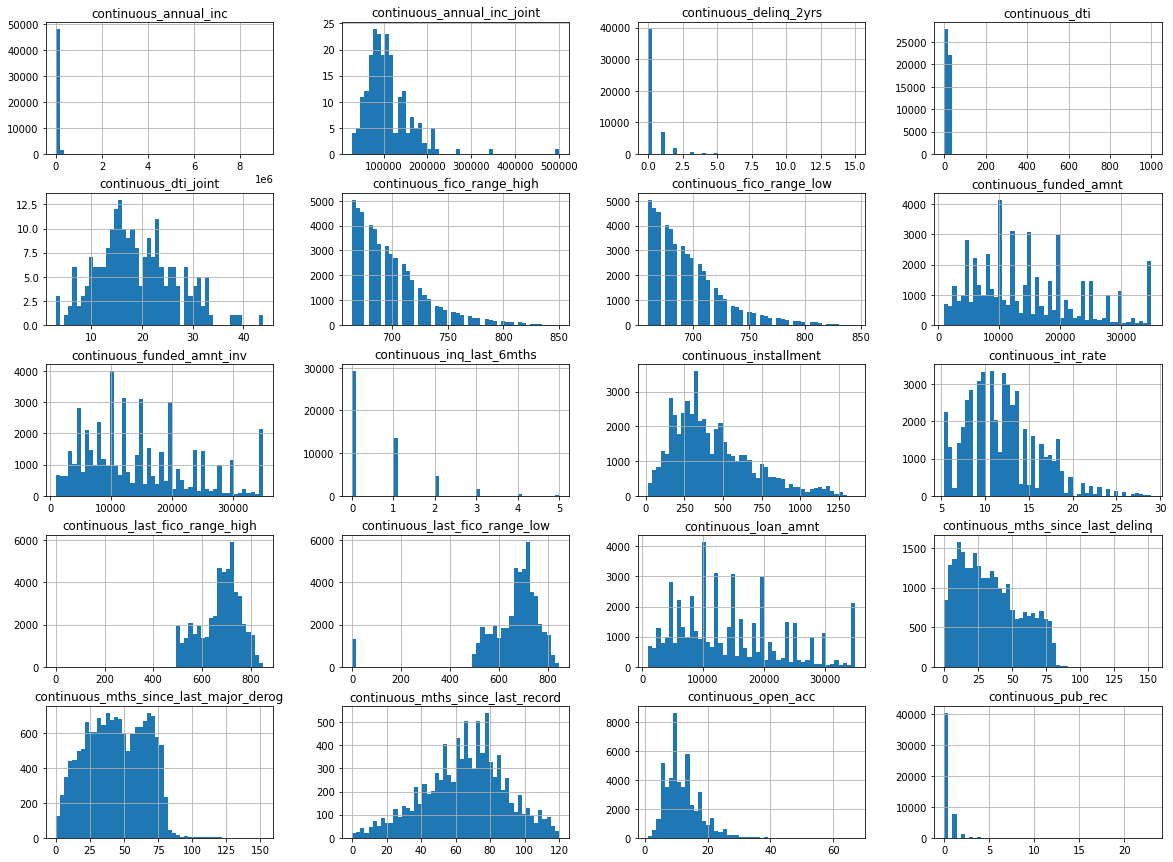

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
loans_c.hist(bins=50, figsize=(20,15))
plt.show()

(array([  38.,  626., 2236., 4675., 6207., 6497., 6287., 5250., 4065.,
        3087., 2569., 1674., 1804.,  998.,  698.,  807.,  429.,  326.,
         283.,  133.,  267.,   98.,  137.,   68.,   58.,  147.,   46.,
          37.,   39.]),
 array([     0,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
         80000,  90000, 100000, 110000, 120000, 130000, 140000, 150000,
        160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000,
        240000, 250000, 260000, 270000, 280000, 290000]),
 <a list of 29 Patch objects>)

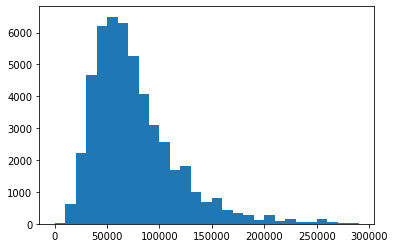

In [16]:
plt.hist(loans_c.continuous_annual_inc, bins=np.arange(0,300000,10000))

(array([2.0140e+03, 6.1440e+03, 9.5220e+03, 1.0326e+04, 8.9680e+03,
        6.8500e+03, 4.1960e+03, 1.9380e+03, 9.0000e+00, 1.2000e+01,
        6.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
        85, 90, 95]),
 <a list of 19 Patch objects>)

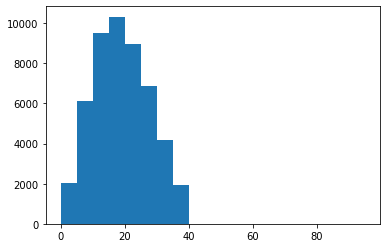

In [17]:
plt.hist(loans_c.continuous_dti, bins=np.arange(0,100,5))

###探索发现
本次贷款相关变量
1.   funded_amnt 与 loan_amnt 两列完全相同；
2.   funded_amnt 与funded_amnt_inv,有3163条记录有差异。尝试两列相减后作为新特征

借款人实力
3.   annual_inc_joint与dti_joint绝大多数为空，说明仅少量贷款为联名申请。application_type标识是否为联名申请
4.   根据计算，dti（还款额除以月收入）是指总还款额，不是本次贷款还款额，dti值越小越好
6.   annual_inc和dti的数据有明显异常点，如annual_inc的最大值为9百万

借款人信用记录
7.   当pub_rec不为0，mths_since_last_record才有相应数据，否则为空 
8.   有delinq的人比major_derog的多。感觉deling拖欠较普遍，而major_derog是更严重的负面指标
9.   mths_since_last_record、mths_since_last_delinq、mths_since_last_major_derog的空值 ~LGB算法可以自动处理空值

# Get baseline


*   原则上baseline的调参力度最大。后续每轮try调参可以小于baseline调参力度，其效果有提升可说明新特征有效。
*   baseline的调参范围较大，为节省时间每轮try先采用
baseline参数的子集，如果结果中最好的参数位于边缘，则向边缘适当再扩展。例如，param_grid的num_leaves为15，16，17，发现最好的num_leaves为17，故在原有param_grid上再增加num_leaves 18做尝试。
*   如下特征工程部分的代码展现了新特征的构建，但不展现完整的迭代调参过程。
*   所有try的调参参数和最终结果在EXCEL表格cv_results中记录。
https://github.com/wenkaicn/ML-000/blob/main/Week16/cv_results.xlsx


In [14]:
param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
          'num_leaves': [14,16,18,30,32,33,34,35,36], 'learning_rate': [0.06], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}

df_cv, models = GridSearch(X_train, Y_train, param_grid)
mr.record_cv('baseline',df_cv,models)

0-th model is training:


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


流式输出内容被截断，只能显示最后 5000 行内容。
[31]	training's binary_error: 0.0768	valid_1's binary_error: 0.0783
[32]	training's binary_error: 0.076375	valid_1's binary_error: 0.0779
[33]	training's binary_error: 0.0761	valid_1's binary_error: 0.0777
[34]	training's binary_error: 0.0759	valid_1's binary_error: 0.0774
[35]	training's binary_error: 0.075525	valid_1's binary_error: 0.0771
[36]	training's binary_error: 0.075525	valid_1's binary_error: 0.0771
[37]	training's binary_error: 0.0754	valid_1's binary_error: 0.0774
[38]	training's binary_error: 0.0751	valid_1's binary_error: 0.0774
[39]	training's binary_error: 0.0751	valid_1's binary_error: 0.0773
[40]	training's binary_error: 0.07495	valid_1's binary_error: 0.0774
[41]	training's binary_error: 0.074925	valid_1's binary_error: 0.0773
[42]	training's binary_error: 0.074725	valid_1's binary_error: 0.0772
[43]	training's binary_error: 0.07465	valid_1's binary_error: 0.0774
[44]	training's binary_error: 0.074625	valid_1's binary_error: 0.0776
[45]	tr

In [15]:
# mr.filter_man('baseline',12)
# mr.test('baseline', X_test, Y_test)
mr.dump()

# try-1 连续变量除法
增加变量：已有的dti不包含本次贷款金额，因此构造变量loan_income = installment / (annual_inc/12) 表明本次借款月还款额与月收入比值


In [13]:
X_train1 = deepcopy(X_train)
X_train1['continuous_loan_income'] = X_train1['continuous_installment'] / (X_train1['continuous_annual_inc'] / 12)
X_test1 = deepcopy(X_test)
X_test1['continuous_loan_income'] = X_test1['continuous_installment'] / (X_test1['continuous_annual_inc'] / 12)


In [ ]:
param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
          'num_leaves': [14,16,18,30,32,34,36], 'learning_rate': [0.01,0.02,0.03], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}


df_cv, models = GridSearch(X_train1, Y_train, param_grid)
mr.record_cv('try1',df_cv,models)


0-th model is training:


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


流式输出内容被截断，只能显示最后 5000 行内容。
[503]	training's binary_error: 0.0715	valid_1's binary_error: 0.0788
[504]	training's binary_error: 0.071525	valid_1's binary_error: 0.0788
[505]	training's binary_error: 0.071525	valid_1's binary_error: 0.0788
[506]	training's binary_error: 0.0715	valid_1's binary_error: 0.0788
[507]	training's binary_error: 0.0715	valid_1's binary_error: 0.0789
[508]	training's binary_error: 0.071475	valid_1's binary_error: 0.0787
[509]	training's binary_error: 0.071475	valid_1's binary_error: 0.0787
[510]	training's binary_error: 0.071475	valid_1's binary_error: 0.0787
[511]	training's binary_error: 0.07145	valid_1's binary_error: 0.0787
[512]	training's binary_error: 0.07135	valid_1's binary_error: 0.0786
[513]	training's binary_error: 0.07135	valid_1's binary_error: 0.0786
[514]	training's binary_error: 0.0713	valid_1's binary_error: 0.0786
[515]	training's binary_error: 0.071275	valid_1's binary_error: 0.0786
[516]	training's binary_error: 0.0713	valid_1's binary_error:

In [17]:
df_cv.sort_values(['val_error'],ascending=True)

num_leaves  learning_rate  val_error  train_error  iter_0  iter_1  iter_2  \
14          14           0.03    0.07930     0.076295     102     136      79   
2           18           0.01    0.07932     0.075065     290     358     258   
16          18           0.03    0.07932     0.075050      89     151      95   
15          16           0.03    0.07936     0.074790      88     112      75   
7           14           0.02    0.07936     0.076575     145     233     115   
18          32           0.03    0.07940     0.067630     242     123     106   
17          30           0.03    0.07940     0.070795     188     132     124   
9           18           0.02    0.07942     0.073280     127     225     124   
11          32           0.02    0.07942     0.071595      99     242     119   
19          34           0.03    0.07944     0.069320      68     149      85   
8           16           0.02    0.07950     0.075905     140     303     125   
6           36           0.01    0.07952     0.069590     286     448     383   
10          30           0.02    0.07952     0.072260     156     230     113   
4           32           0.01    0.07954     0.071510     290     487     300   
1           16           0.01    0.07954     0.076175     258     462     258   
13          36           0.02    0.07958     0.069585     136     220     170   
12          34           0.02    0.07960     0.070205     138     216     142   
20          36           0.03    0.07970     0.070885      73     127     126   
0           14           0.01    0.07974     0.077175     289     275     228   
3           30           0.01    0.07982     0.072970     288     391     267   
5           34           0.01    0.07984     0.072320     309     387     328   

    iter_3  iter_4  
14     205     383  
2      999     676  
16     137     373  
15     185     652  
7      345     417  
18     343     446  
17     219     308  
9      422     999  
11     204     416  
19     292     350  
8      291     371  
6      432    1000  
10     231     334  
4      394     745  
1      633     711  
13     228     510  
12     345     442  
20     113     259  
0      584     788  
3      372     462  
5      216     472

In [18]:
# mr.filter_man('try1',10)
# mr.test('try1', X_test1, Y_test)
mr.dump()

发现：在测试集上的效果提升: 0.91814-0.91792= 0.022%，效果较显著

# try-2 连续变量除法补充
在try-1的基础上，针对共同借款人，构造类似的特征：月还款额/共同借款人的月收入

In [9]:
X_train2 = deepcopy(X_train)
X_train2['continuous_loan_income_joint'] = X_train2['continuous_installment'] / (X_train2['continuous_annual_inc_joint'] / 12)
X_test2 = deepcopy(X_test)
X_test2['continuous_loan_income_joint'] = X_test2['continuous_installment'] / (X_test2['continuous_annual_inc_joint'] / 12)


In [12]:

param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
          'num_leaves': [36], 'learning_rate': [0.03,0.04], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}

df_cv, models = GridSearch(X_train2, Y_train, param_grid)
mr.record_cv('try2',df_cv,models)


0-th model is training:


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
Training until validation scores don't improve for 200 rounds.
[2]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[3]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[4]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[5]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[6]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[7]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[8]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[9]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[10]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[11]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[12]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[13]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[14]	training's binary_error: 0.2037

In [27]:
df_cv.sort_values(['val_error'],ascending=True)

num_leaves  learning_rate  val_error  train_error  iter_0  iter_1  iter_2  \
14          36           0.02    0.07900     0.071060     119     137     147   
13          34           0.02    0.07902     0.070385     105     164     154   
21          34           0.03    0.07910     0.066860      69     113      69   
20          32           0.03    0.07912     0.071365      68     118     109   
19          30           0.03    0.07918     0.070740     239      93     103   
4           32           0.01    0.07928     0.072545     219     375     315   
12          32           0.02    0.07928     0.070220     105     206     146   
3           30           0.01    0.07930     0.071470     237     388     239   
11          30           0.02    0.07934     0.072310     106     154     113   
5           34           0.01    0.07934     0.072935     216     354     256   
10          22           0.02    0.07938     0.074060     115     175     106   
16          18           0.03    0.07940     0.073820     303     114      75   
23          38           0.03    0.07940     0.070425      72     108     116   
15          38           0.02    0.07942     0.069705     101     156     138   
7           38           0.01    0.07942     0.071830     219     308     287   
22          36           0.03    0.07946     0.070705      77     108      65   
18          22           0.03    0.07948     0.073200      64     106      69   
9           20           0.02    0.07950     0.074450     103     157     179   
8           18           0.02    0.07952     0.075720     102     219     121   
6           36           0.01    0.07952     0.072410     210     266     288   
17          20           0.03    0.07954     0.072690     336     126     119   
1           20           0.01    0.07972     0.075380     206     443     262   
2           22           0.01    0.07974     0.075185     252     346     236   
0           18           0.01    0.07980     0.075235     221     374     381   

    iter_3  iter_4  
14     207     400  
13     308     517  
21     358     621  
20     250     251  
19     286     259  
4      370     530  
12     221     684  
3      647     992  
11     349     382  
5      207     459  
10     267     637  
16     324     388  
23      67     330  
15     297     464  
7      200     481  
22      80     365  
18     251     532  
9      444     496  
8      175     552  
6      234     482  
17     340     357  
1      478     744  
2      351     684  
0      658     999

In [13]:
# mr.filter_man('try2',14)
# mr.test('try2', X_test2, Y_test)
mr.dump()

发现：新增共同借款人的相关变量，与baseline相比有轻微降低。此方法无效。

# try-3 连续变量减法
funded_amnt 与funded_amnt_inv,有3163条记录有差异。尝试：两列相减后作为新特征。


In [ ]:
X_train3 = deepcopy(X_train)
X_train3['continuous_gap'] = X_train3['continuous_funded_amnt'] - X_train3['continuous_funded_amnt_inv']

X_test3 = deepcopy(X_test)
X_test3['continuous_gap'] = X_test3['continuous_funded_amnt'] - X_test3['continuous_funded_amnt_inv']


param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
          'num_leaves': [16,18,20,22,30,32,34,36,38], 'learning_rate': [0.01,0.02,0.03], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}

df_cv, models = GridSearch(X_train3, Y_train, param_grid)
mr.record_cv('try3',df_cv,models)

0-th model is training:


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


流式输出内容被截断，只能显示最后 5000 行内容。
[539]	training's binary_error: 0.075675	valid_1's binary_error: 0.0769
[540]	training's binary_error: 0.075675	valid_1's binary_error: 0.0769
[541]	training's binary_error: 0.075675	valid_1's binary_error: 0.0769
[542]	training's binary_error: 0.0757	valid_1's binary_error: 0.0769
[543]	training's binary_error: 0.0757	valid_1's binary_error: 0.0769
[544]	training's binary_error: 0.075725	valid_1's binary_error: 0.0769
[545]	training's binary_error: 0.075725	valid_1's binary_error: 0.0769
[546]	training's binary_error: 0.0757	valid_1's binary_error: 0.0769
[547]	training's binary_error: 0.07575	valid_1's binary_error: 0.0768
[548]	training's binary_error: 0.075725	valid_1's binary_error: 0.0768
[549]	training's binary_error: 0.075675	valid_1's binary_error: 0.0768
[550]	training's binary_error: 0.07575	valid_1's binary_error: 0.0768
[551]	training's binary_error: 0.0757	valid_1's binary_error: 0.077
[552]	training's binary_error: 0.07565	valid_1's binary_error

In [ ]:
df_cv.sort_values(['val_error'],ascending=True)

In [ ]:
#num_leaves 34验证错误率最低，但同时其训练错误率过低，判断过拟合。选择num_leaves30做测试
# mr.filter_man('try3',22)
# mr.test('try3', X_test3, Y_test)
mr.dump()

发现：在测试集上的效果提升: 0.91818-0.91792= 0.026%，效果较显著,比try1的提升还要多。

# try-4 离散变量count编码
对于“addr_state，emp_length，grade，purpose，sub_grade”列，统一用count编码替代onehot编码

In [11]:
X_train4 = deepcopy(X_train)
X_test4 = deepcopy(X_test)

addr_state_features = [col for col in loans.columns if col.startswith('discrete_addr_state')]
emp_length_features = [col for col in loans.columns if col.startswith('discrete_emp_length')]
grade_features   = [col for col in loans.columns if col.startswith('discrete_grade')]
sub_grade_features = [col for col in loans.columns if col.startswith('discrete_sub_grade')]
purpose_features =  [col for col in loans.columns if col.startswith('discrete_purpose')]

new_features = {'discrete_addr_state': addr_state_features,
            'discrete_emp_length': emp_length_features,
            'discrete_grade': grade_features,
            'discrete_sub_grade': sub_grade_features,
            'discrete_purpose': purpose_features}

all_data = pd.concat([X_train4, X_test4])

def one_hot_merge(row, features, encoding_map):
  for one_hot_num in features:
    if row[one_hot_num] == 1:
      return encoding_map[one_hot_num]

def count_encode(all_data, new_features):
  for key,features in new_features.items():
    encoding_map = all_data[features].sum()
    count_encoded = all_data.apply(one_hot_merge, axis=1, 
                     features=features, encoding_map=encoding_map)
    all_data[key] = count_encoded
    all_data = all_data.drop(labels=features, axis = 1)
  return all_data

all_data = count_encode(all_data, new_features)

X_train4 = all_data.iloc[:50000, :]
X_test4 = all_data.iloc[50000:, :]


In [21]:
param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
          'num_leaves': [17,19,21,23,31,33,35], 'learning_rate': [0.01,0.02,0.03], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}

df_cv, models = GridSearch(X_train4, Y_train, param_grid)

0-th model is training:


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


流式输出内容被截断，只能显示最后 5000 行内容。
[76]	training's binary_error: 0.07405	valid_1's binary_error: 0.0833
[77]	training's binary_error: 0.0739	valid_1's binary_error: 0.0829
[78]	training's binary_error: 0.07385	valid_1's binary_error: 0.0831
[79]	training's binary_error: 0.073775	valid_1's binary_error: 0.0833
[80]	training's binary_error: 0.07355	valid_1's binary_error: 0.083
[81]	training's binary_error: 0.0737	valid_1's binary_error: 0.083
[82]	training's binary_error: 0.0737	valid_1's binary_error: 0.0832
[83]	training's binary_error: 0.073425	valid_1's binary_error: 0.0827
[84]	training's binary_error: 0.073375	valid_1's binary_error: 0.0827
[85]	training's binary_error: 0.073325	valid_1's binary_error: 0.0828
[86]	training's binary_error: 0.073225	valid_1's binary_error: 0.0827
[87]	training's binary_error: 0.073225	valid_1's binary_error: 0.0829
[88]	training's binary_error: 0.0728	valid_1's binary_error: 0.0829
[89]	training's binary_error: 0.072875	valid_1's binary_error: 0.083
[90]	tr

In [22]:
df_cv.sort_values(['val_error'],ascending=True)

num_leaves  learning_rate  val_error  train_error  iter_0  iter_1  iter_2  \
19          33           0.03    0.07932     0.070960      95     160      95   
12          33           0.02    0.07942     0.071910      96     210     168   
20          35           0.03    0.07946     0.071130      63     132      76   
14          17           0.03    0.07950     0.075600      68     153     105   
6           35           0.01    0.07958     0.071625     256     411     305   
13          35           0.02    0.07962     0.072000     127     226     161   
5           33           0.01    0.07966     0.072120     267     411     309   
16          21           0.03    0.07966     0.074305     213     136     116   
9           21           0.02    0.07966     0.074330     141     228     177   
2           21           0.01    0.07968     0.074915     230     445     394   
4           31           0.01    0.07970     0.072385     273     452     350   
15          19           0.03    0.07970     0.074890      84     108      99   
18          31           0.03    0.07972     0.070905      70     139     106   
17          23           0.03    0.07972     0.072035     296     122     118   
1           19           0.01    0.07974     0.075385     190     426     317   
0           17           0.01    0.07976     0.075585     201     408     449   
11          31           0.02    0.07982     0.070245     108     235     338   
3           23           0.01    0.07984     0.074650     250     442     324   
10          23           0.02    0.07984     0.073680     150     239     144   
7           17           0.02    0.07986     0.075565     104     179     228   
8           19           0.02    0.07998     0.073370     114     217     158   

    iter_3  iter_4  
19     238     205  
12      97     431  
20     150     251  
14     249     340  
6      357     452  
13      99     276  
5      197     790  
16      96     306  
9      205     488  
2      584     617  
4      408     527  
15     135     450  
18      83     428  
17     129     456  
1      399     997  
0      574     995  
11     189     548  
3      429     570  
10     272     472  
7      470     348  
8      303    1000

In [25]:
mr.record_cv('try4',df_cv,models)
mr.filter_man('try4', 19)
mr.test('try4', X_test4, Y_test)
mr.dump()


发现：相比baseline，在测试集上的效果提升了: 0.91804-0.91792=0.012%，有点效果

# try-5 离散变量Target encoding
在已有count encoding的基础上，更改为Target encoding

In [27]:
X_train5 = deepcopy(X_train4)
X_test5 = deepcopy(X_test4)

from category_encoders import *
enc = TargetEncoder(cols=['discrete_emp_length', 
              'discrete_grade', 
              'discrete_sub_grade',
              'discrete_purpose',
              'discrete_addr_state'
              ]).fit(X_train5, Y_train)
X_train5 = enc.transform(X_train5)
X_test5 = enc.transform(X_test5)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [29]:
X_train5.head()

continuous_annual_inc  continuous_annual_inc_joint  continuous_delinq_2yrs  \
0                55000.0                          NaN                     0.0   
1                65000.0                          NaN                     1.0   
2                63000.0                      71000.0                     0.0   
3               104433.0                          NaN                     1.0   
4                34000.0                          NaN                     0.0   

   continuous_dti  continuous_dti_joint  continuous_fico_range_high  \
0            5.91                   NaN                       679.0   
1           16.06                   NaN                       719.0   
2           10.78                 13.85                       699.0   
3           25.37                   NaN                       699.0   
4           10.20                   NaN                       694.0   

   continuous_fico_range_low  continuous_funded_amnt  \
0                      675.0                  3600.0   
1                      715.0                 24700.0   
2                      695.0                 20000.0   
3                      695.0                 10400.0   
4                      690.0                 11950.0   

   continuous_funded_amnt_inv  continuous_inq_last_6mths  \
0                      3600.0                        1.0   
1                     24700.0                        4.0   
2                     20000.0                        0.0   
3                     10400.0                        3.0   
4                     11950.0                        0.0   

   continuous_installment  continuous_int_rate  \
0                  123.03                13.99   
1                  820.28                11.99   
2                  432.66                10.78   
3                  289.91                22.45   
4                  405.18                13.44   

   continuous_last_fico_range_high  continuous_last_fico_range_low  \
0                            564.0                           560.0   
1                            699.0                           695.0   
2                            704.0                           700.0   
3                            704.0                           700.0   
4                            759.0                           755.0   

   continuous_loan_amnt  continuous_mths_since_last_delinq  \
0                3600.0                               30.0   
1               24700.0                                6.0   
2               20000.0                                NaN   
3               10400.0                               12.0   
4               11950.0                                NaN   

   continuous_mths_since_last_major_derog  continuous_mths_since_last_record  \
0                                    30.0                                NaN   
1                                     NaN                                NaN   
2                                     NaN                                NaN   
3                                     NaN                                NaN   
4                                     NaN                                NaN   

   continuous_open_acc  continuous_pub_rec  \
0                  7.0                 0.0   
1                 22.0                 0.0   
2                  6.0                 0.0   
3                 12.0                 0.0   
4                  5.0                 0.0   

   discrete_application_type_1_one_hot  discrete_application_type_2_one_hot  \
0                                    1                                    0   
1                                    1                                    0   
2                                    0                                    1   
3                                    1                                    0   
4                                    1                                    0   

   discrete_home_ownership_1_one_hot  discrete_home_ownership_2

In [39]:
param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
          'num_leaves': [17,19,21,23], 'learning_rate': [0.01,0.02,0.03,0.04,0.05], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}

df_cv, models = GridSearch(X_train5, Y_train, param_grid)
mr.record_cv('try5',df_cv,models)

0-th model is training:
[1]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
Training until validation scores don't improve for 200 rounds.
[2]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


流式输出内容被截断，只能显示最后 5000 行内容。
[71]	training's binary_error: 0.07645	valid_1's binary_error: 0.0806
[72]	training's binary_error: 0.0765	valid_1's binary_error: 0.0806
[73]	training's binary_error: 0.0765	valid_1's binary_error: 0.0804
[74]	training's binary_error: 0.0764	valid_1's binary_error: 0.0804
[75]	training's binary_error: 0.0763	valid_1's binary_error: 0.0802
[76]	training's binary_error: 0.07645	valid_1's binary_error: 0.0805
[77]	training's binary_error: 0.07635	valid_1's binary_error: 0.0805
[78]	training's binary_error: 0.0763	valid_1's binary_error: 0.0807
[79]	training's binary_error: 0.076225	valid_1's binary_error: 0.0807
[80]	training's binary_error: 0.076225	valid_1's binary_error: 0.0804
[81]	training's binary_error: 0.076225	valid_1's binary_error: 0.0804
[82]	training's binary_error: 0.07615	valid_1's binary_error: 0.0803
[83]	training's binary_error: 0.076025	valid_1's binary_error: 0.08
[84]	training's binary_error: 0.0759	valid_1's binary_error: 0.0805
[85]	traini

In [40]:
df_cv.sort_values(['val_error'],ascending=True)

num_leaves  learning_rate  val_error  train_error  iter_0  iter_1  iter_2  \
5           19           0.02    0.07896     0.075155     138     167     122   
7           23           0.02    0.07898     0.074310     135     189     106   
2           21           0.01    0.07906     0.075090     230     344     219   
6           21           0.02    0.07912     0.074775     133     157     110   
10          21           0.03    0.07912     0.073530      83     127      84   
15          23           0.04    0.07914     0.073905      66      86      58   
3           23           0.01    0.07916     0.074640     267     328     220   
9           19           0.03    0.07918     0.075340      84     125      85   
18          21           0.05    0.07918     0.074480      50      89      66   
16          17           0.05    0.07922     0.075410      55      79      87   
12          17           0.04    0.07924     0.073840     261      84      78   
0           17           0.01    0.07926     0.076030     306     338     242   
4           17           0.02    0.07928     0.074580     129     184     228   
1           19           0.01    0.07930     0.075515     276     361     228   
8           17           0.03    0.07934     0.075060      82     173     115   
11          23           0.03    0.07938     0.073575      80     132     108   
17          19           0.05    0.07940     0.073190     181     114      41   
19          23           0.05    0.07946     0.073360      50      57      60   
14          21           0.04    0.07952     0.075165      65      76      89   
13          19           0.04    0.07960     0.075235      71     109      72   

    iter_3  iter_4  
5      233     432  
7      257     366  
2      550     714  
6      235     446  
10     257     414  
15     113     251  
3      360     697  
9      125     294  
18     115     123  
16      93     165  
12     130     294  
0      621     622  
4      395     555  
1      382     748  
8      127     386  
11     110     382  
17     155     207  
19     119     216  
14     122     125  
13     185     154

In [45]:
mr.dump()

发现：将count编码更换为Target encoding，相比baseline没有提升

# try-6 删除多余列


In [46]:
X_train6 = deepcopy(X_train)
X_test6 = deepcopy(X_test)

all_data = pd.concat([X_train6, X_test6])

del all_data['continuous_funded_amnt']
del all_data['discrete_policy_code_1_one_hot']
del all_data['discrete_pymnt_plan_1_one_hot']
del all_data['discrete_application_type_1_one_hot']
del all_data['discrete_application_type_2_one_hot']

X_train6 = all_data.iloc[:50000, :]
X_test6 = all_data.iloc[50000:, :]

In [55]:
param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
          'num_leaves': [16,17,18,30,31,32,33,34,36], 'learning_rate': [0.04,0.05], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}

df_cv, models = GridSearch(X_train6, Y_train, param_grid)
mr.record_cv('try6',df_cv,models)

0-th model is training:


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


流式输出内容被截断，只能显示最后 5000 行内容。
[214]	training's binary_error: 0.06435	valid_1's binary_error: 0.0793
[215]	training's binary_error: 0.064275	valid_1's binary_error: 0.0793
[216]	training's binary_error: 0.0643	valid_1's binary_error: 0.0793
[217]	training's binary_error: 0.06405	valid_1's binary_error: 0.0793
[218]	training's binary_error: 0.064025	valid_1's binary_error: 0.0793
[219]	training's binary_error: 0.0639	valid_1's binary_error: 0.0796
[220]	training's binary_error: 0.06385	valid_1's binary_error: 0.0796
[221]	training's binary_error: 0.063825	valid_1's binary_error: 0.0796
[222]	training's binary_error: 0.063875	valid_1's binary_error: 0.0795
[223]	training's binary_error: 0.063875	valid_1's binary_error: 0.0794
[224]	training's binary_error: 0.063825	valid_1's binary_error: 0.0793
[225]	training's binary_error: 0.0637	valid_1's binary_error: 0.0793
[226]	training's binary_error: 0.0635	valid_1's binary_error: 0.0794
[227]	training's binary_error: 0.06355	valid_1's binary_error

In [56]:
mr.dump()

In [57]:
df_cv.sort_values(['val_error'],ascending=True)

num_leaves  learning_rate  val_error  train_error  iter_0  iter_1  iter_2  \
16          34           0.05    0.07936     0.069865     154      65      72   
0           16           0.04    0.07938     0.075495     228      98      85   
4           31           0.04    0.07938     0.070270      48      98      75   
1           17           0.04    0.07942     0.075645      60     105      66   
5           32           0.04    0.07946     0.069060      56      84      67   
6           33           0.04    0.07948     0.068535      57      88      67   
9           16           0.05    0.07952     0.075715      51      71      68   
13          31           0.05    0.07954     0.070565     154      54      54   
7           34           0.04    0.07954     0.067305     175     202      60   
12          30           0.05    0.07962     0.070990      47      60      67   
11          18           0.05    0.07962     0.073695     239      82      58   
8           36           0.04    0.07964     0.069110     191      77      59   
2           18           0.04    0.07964     0.075855      52      81      56   
10          17           0.05    0.07966     0.075420      44      80      65   
15          33           0.05    0.07968     0.069790      55      54      70   
3           30           0.04    0.07970     0.071200      72      99      85   
17          36           0.05    0.07974     0.068945      46      91      61   
14          32           0.05    0.07978     0.069575     121      76      44   

    iter_3  iter_4  
16      44     204  
0       98     205  
4      143     389  
1      195     246  
5      173     414  
6      319     307  
9      132     205  
13      54     237  
7      207     301  
12     140     238  
11     108     267  
8      133     231  
2      162     252  
10      82     291  
15     142     244  
3      202     231  
17     157     214  
14     108     278

In [59]:
test_model(X_test6, Y_test, models[16])
# dict_test

0.91822

发现：0.91822-0.91792= 0.03%。效果较明显。但0.91822是多次测试后获得，这样是否合理？如果选择0.918-0.91792=0.008%，删除多余变量相比baseline仅略微一点提升。从道理上删除多余变量应该是有效的。

# try-7 连续变量与离散变量的交叉
按不同地区算收入平均值，构造新特征：个人收入/地区收入平均值 

In [12]:
X_train7 = deepcopy(X_train4)
X_test7 = deepcopy(X_test4)

#dataframe记录各特征的州平均值。为避免收入异常值的影响，这里用中位数median
df_state_mean = X_train7.groupby('discrete_addr_state').median() 

new_features = {'annual_inc_ratio': 'continuous_annual_inc',
          #'dti_ratio': 'continuous_dti',
          'installment_ratio': 'continuous_installment',
          #'loan_amnt_ratio': 'continuous_loan_amnt',
          #'pub_rec_ratio': 'continuous_pub_rec'
          }

def ratio_generator(row, feature): 
  state = row['discrete_addr_state'] #借款人所在州
  state_mean = df_state_mean[feature][state] #借款人所在州平均值（当feature为continuous_annual_inc即平均工资）
  return row[feature] / state_mean  #借款人的值与所在州平均值的比率

for new_feature_name, feature in new_features.items():
  X_train7[new_feature_name] = X_train7.apply(ratio_generator, axis=1, feature=feature)
  X_test7[new_feature_name] = X_test7.apply(ratio_generator, axis=1, feature=feature)


In [18]:
param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
          'num_leaves': [33,35], 'learning_rate': [0.01,0.02,0.03,0.04,0.05], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}

df_cv, models = GridSearch(X_train7, Y_train, param_grid)
mr.record_cv('try7',df_cv,models)
mr.dump()


0-th model is training:


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


流式输出内容被截断，只能显示最后 5000 行内容。
[43]	training's binary_error: 0.074325	valid_1's binary_error: 0.0795
[44]	training's binary_error: 0.0741	valid_1's binary_error: 0.0794
[45]	training's binary_error: 0.074075	valid_1's binary_error: 0.0793
[46]	training's binary_error: 0.073775	valid_1's binary_error: 0.0796
[47]	training's binary_error: 0.073675	valid_1's binary_error: 0.0799
[48]	training's binary_error: 0.0737	valid_1's binary_error: 0.0793
[49]	training's binary_error: 0.073475	valid_1's binary_error: 0.0797
[50]	training's binary_error: 0.073575	valid_1's binary_error: 0.0795
[51]	training's binary_error: 0.0738	valid_1's binary_error: 0.0798
[52]	training's binary_error: 0.0737	valid_1's binary_error: 0.0796
[53]	training's binary_error: 0.0737	valid_1's binary_error: 0.0794
[54]	training's binary_error: 0.0735	valid_1's binary_error: 0.0794
[55]	training's binary_error: 0.0734	valid_1's binary_error: 0.0792
[56]	training's binary_error: 0.07345	valid_1's binary_error: 0.0792
[57]	tra

In [19]:
mr.cv_results['try7'].sort_values(['val_error'],ascending=True)

num_leaves  learning_rate  val_error  train_error  iter_0  iter_1  iter_2  \
6          33           0.04    0.07934     0.070345      53      94      96   
4          33           0.03    0.07942     0.069450      65     123     119   
8          33           0.05    0.07950     0.068450      40     116     222   
5          35           0.03    0.07960     0.070720      70     145     100   
7          35           0.04    0.07962     0.068950      55      89      92   
2          33           0.02    0.07978     0.071400     116     199     120   
0          33           0.01    0.07982     0.071915     202     410     301   
1          35           0.01    0.07982     0.071865     209     404     324   
3          35           0.02    0.07984     0.071105     129     174     190   
9          35           0.05    0.07988     0.066905      40      86      56   

   iter_3  iter_4  
6     199     184  
4      65     524  
8     120     147  
5     124     253  
7     110     338  
2     283     299  
0     403     507  
1     202     601  
3      93     391  
9      37     436

In [20]:
# dict_models['try7'] = models[20]
# dict_test['try7'] = test_model(X_test7, Y_test, models[20])
# dict_test
mr.filter_man('try7', 6)
mr.test('try7',X_test7,Y_test)

0.91806

In [21]:
X_train7.head()

continuous_annual_inc  continuous_annual_inc_joint  continuous_delinq_2yrs  \
0                55000.0                          NaN                     0.0   
1                65000.0                          NaN                     1.0   
2                63000.0                      71000.0                     0.0   
3               104433.0                          NaN                     1.0   
4                34000.0                          NaN                     0.0   

   continuous_dti  continuous_dti_joint  continuous_fico_range_high  \
0            5.91                   NaN                       679.0   
1           16.06                   NaN                       719.0   
2           10.78                 13.85                       699.0   
3           25.37                   NaN                       699.0   
4           10.20                   NaN                       694.0   

   continuous_fico_range_low  continuous_funded_amnt  \
0                      675.0                  3600.0   
1                      715.0                 24700.0   
2                      695.0                 20000.0   
3                      695.0                 10400.0   
4                      690.0                 11950.0   

   continuous_funded_amnt_inv  continuous_inq_last_6mths  \
0                      3600.0                        1.0   
1                     24700.0                        4.0   
2                     20000.0                        0.0   
3                     10400.0                        3.0   
4                     11950.0                        0.0   

   continuous_installment  continuous_int_rate  \
0                  123.03                13.99   
1                  820.28                11.99   
2                  432.66                10.78   
3                  289.91                22.45   
4                  405.18                13.44   

   continuous_last_fico_range_high  continuous_last_fico_range_low  \
0                            564.0                           560.0   
1                            699.0                           695.0   
2                            704.0                           700.0   
3                            704.0                           700.0   
4                            759.0                           755.0   

   continuous_loan_amnt  continuous_mths_since_last_delinq  \
0                3600.0                               30.0   
1               24700.0                                6.0   
2               20000.0                                NaN   
3               10400.0                               12.0   
4               11950.0                                NaN   

   continuous_mths_since_last_major_derog  continuous_mths_since_last_record  \
0                                    30.0                                NaN   
1                                     NaN                                NaN   
2                                     NaN                                NaN   
3                                     NaN                                NaN   
4                                     NaN                                NaN   

   continuous_open_acc  continuous_pub_rec  \
0                  7.0                 0.0   
1                 22.0                 0.0   
2                  6.0                 0.0   
3                 12.0                 0.0   
4                  5.0                 0.0   

   discrete_application_type_1_one_hot  discrete_application_type_2_one_hot  \
0                                    1                                    0   
1                                    1                                    0   
2                                    0                                    1   
3                                    1                                    0   
4                                    1                                    0   

   discrete_home_ownership_1_one_hot  discrete_home_ownership_2

发现：数据集是在try4基础上，因此与try4比提升：0，91806-0.91804=0.002%。基本没效果。各地区的收入水平不同。先算出地区收入平均值（中位数），再得到个人收入与平均收入的比值，从道理上看应该是比单纯的个人收入更有用的变量，但实际验证发现没有效果上的提升。
暂不知哪一步还没做到位。。。

# try-8 信用变量的乘法
continuous_open_acc / continuous_pub_rec /continuous_delinq_2yrs, 将这几个信用相关的变量相乘

In [22]:
X_train8 = deepcopy(X_train)
X_test8 = deepcopy(X_test)
X_train8['credit_score'] = X_train8['continuous_open_acc'] * X_train8['continuous_pub_rec'] * X_train8['continuous_delinq_2yrs']
X_test8['credit_score'] = X_test8['continuous_open_acc'] * X_test8['continuous_pub_rec'] * X_test8['continuous_delinq_2yrs']


In [29]:
param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
          'num_leaves': [31,33,35], 'learning_rate': [0.01,0.02,0.03,0.04,0.05], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}

df_cv, models = GridSearch(X_train8, Y_train, param_grid)
mr.record_cv('try8',df_cv,models)

0-th model is training:


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


流式输出内容被截断，只能显示最后 5000 行内容。
[233]	training's binary_error: 0.065725	valid_1's binary_error: 0.0783
[234]	training's binary_error: 0.06565	valid_1's binary_error: 0.0782
[235]	training's binary_error: 0.065525	valid_1's binary_error: 0.0782
[236]	training's binary_error: 0.065525	valid_1's binary_error: 0.0782
[237]	training's binary_error: 0.06545	valid_1's binary_error: 0.0784
[238]	training's binary_error: 0.065375	valid_1's binary_error: 0.0784
[239]	training's binary_error: 0.0653	valid_1's binary_error: 0.0784
[240]	training's binary_error: 0.06515	valid_1's binary_error: 0.0784
[241]	training's binary_error: 0.065	valid_1's binary_error: 0.0783
[242]	training's binary_error: 0.064925	valid_1's binary_error: 0.0783
[243]	training's binary_error: 0.064825	valid_1's binary_error: 0.0782
[244]	training's binary_error: 0.06465	valid_1's binary_error: 0.0784
[245]	training's binary_error: 0.06455	valid_1's binary_error: 0.0783
[246]	training's binary_error: 0.064525	valid_1's binary_err

In [35]:

df_cv.sort_values(['val_error'],ascending=True)

num_leaves  learning_rate  val_error  train_error  iter_0  iter_1  iter_2  \
9           31           0.04    0.07892     0.071035      52      72      67   
8           35           0.03    0.07900     0.070630      72      96      67   
10          33           0.04    0.07902     0.069935     132      68      67   
0           31           0.01    0.07908     0.071195     232     377     240   
1           33           0.01    0.07916     0.072350     208     326     247   
11          35           0.04    0.07920     0.068655     195     122      58   
12          31           0.05    0.07922     0.072035      34     105      62   
3           31           0.02    0.07930     0.072300     117     153     161   
5           35           0.02    0.07930     0.069845     111     145      98   
4           33           0.02    0.07932     0.069545      96     143     130   
6           31           0.03    0.07936     0.071350     218      93      73   
7           33           0.03    0.07940     0.070455      76     128      72   
14          35           0.05    0.07944     0.070670      37      64      63   
2           35           0.01    0.07958     0.071940     218     350     270   
13          33           0.05    0.07964     0.070735      44      65      72   

    iter_3  iter_4  
9      230     229  
8      215     288  
10     176     245  
0      659     998  
1      374     696  
11     153     219  
12     111     144  
3      357     245  
5      508     464  
4      502     611  
6      160     266  
7      235     331  
14      97     198  
2      480     465  
13      78     220

In [37]:
#test_model(X_test8, Y_test, models[9])
#mr.dump()

发现： 0.91794-0.91792=0.002%。几个信用变量相乘没有效果提升

#try-9 one-hot编码还原
grade和sub_grade都是one-hot编码。推测原始数据中的grade是信用等级，因此不同等级的用户信用是存在排序的，尝试将one-hot编码转为顺序的数字。


In [52]:
X_train9 = deepcopy(X_train)
X_test9 = deepcopy(X_test)

all_data = pd.concat([X_train9, X_test9])

grade_columns   = [col for col in loans.columns if col.startswith('discrete_grade')]
sub_grade_columns = [col for col in loans.columns if col.startswith('discrete_sub_grade')]

def fill_grade(row):
  for idx, value in enumerate(grade_columns):    
    if row[value] == 1:
      return idx+1

def fill_sub_grade(row):
  for idx, value in enumerate(sub_grade_columns):    
    if row[value] == 1:
      return idx+1

all_data['grade'] = all_data.apply(fill_grade, axis=1)
all_data['sub_grade'] = all_data.apply(fill_sub_grade, axis=1)

X_train9 = all_data.iloc[:50000, :]
X_test9 = all_data.iloc[50000:, :]

In [64]:
param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [2000],
          'num_leaves': [15,17,29,31], 'learning_rate': [0.01], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}


df_cv, models = GridSearch(X_train9, Y_train, param_grid)
mr.record_cv('try9',df_cv,models)

0-th model is training:


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


流式输出内容被截断，只能显示最后 5000 行内容。
[40]	training's binary_error: 0.2043	valid_1's binary_error: 0.204
[41]	training's binary_error: 0.2043	valid_1's binary_error: 0.204
[42]	training's binary_error: 0.2043	valid_1's binary_error: 0.204
[43]	training's binary_error: 0.2043	valid_1's binary_error: 0.204
[44]	training's binary_error: 0.2043	valid_1's binary_error: 0.204
[45]	training's binary_error: 0.2043	valid_1's binary_error: 0.204
[46]	training's binary_error: 0.2043	valid_1's binary_error: 0.204
[47]	training's binary_error: 0.2043	valid_1's binary_error: 0.204
[48]	training's binary_error: 0.2043	valid_1's binary_error: 0.204
[49]	training's binary_error: 0.2043	valid_1's binary_error: 0.204
[50]	training's binary_error: 0.2043	valid_1's binary_error: 0.204
[51]	training's binary_error: 0.2043	valid_1's binary_error: 0.204
[52]	training's binary_error: 0.15695	valid_1's binary_error: 0.1553
[53]	training's binary_error: 0.15695	valid_1's binary_error: 0.1553
[54]	training's binary_error: 0

In [65]:
mr.dump()

In [66]:
df_cv.sort_values(['val_error'],ascending=True)

num_leaves  learning_rate  val_error  train_error  iter_0  iter_1  iter_2  \
3          31           0.01    0.07890     0.071630     216     408     264   
2          29           0.01    0.07912     0.072355     215     447     320   
1          17           0.01    0.07934     0.075810     210     430     235   
0          15           0.01    0.07952     0.076795     236     344     272   

   iter_3  iter_4  
3     632     845  
2     362     886  
1     516    1138  
0     517     821

In [68]:
test_model(X_test9, Y_test, models[2])

0.91782

发现：grade和sub_grade转为顺序数字后，效果与baseline比没有提升。emp_length是否做类似的尝试？

# try-10 区分还款周期
term为还款周期（3年期或5年期）。道理上，还款周期长的更容易欠款，是重要影响因素。
构建新特征：不同还款周期的个人信用情况

In [71]:
X_train10 = deepcopy(X_train)
X_test10 = deepcopy(X_test)

X_train10['open_acc_term1'] = X_train10['discrete_term_1_one_hot'] * X_train10['continuous_open_acc']
X_train10['open_acc_term2'] = X_train10['discrete_term_2_one_hot'] * X_train10['continuous_open_acc']
X_test10['open_acc_term1'] = X_test10['discrete_term_1_one_hot'] * X_test10['continuous_open_acc']
X_test10['open_acc_term2'] = X_test10['discrete_term_2_one_hot'] * X_test10['continuous_open_acc']


In [72]:
param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1500],
          'num_leaves': [16,18,20,22,30,32,34,36], 'learning_rate': [0.01,0.02,0.03,0.04,0.05], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}

df_cv, models = GridSearch(X_train10, Y_train, param_grid)
mr.record_cv('try10',df_cv,models)
mr.dump()

0-th model is training:


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Streaming output truncated to the last 5000 lines.
[432]	training's binary_error: 0.0511	valid_1's binary_error: 0.0807
[433]	training's binary_error: 0.051	valid_1's binary_error: 0.0809
[434]	training's binary_error: 0.050975	valid_1's binary_error: 0.0809
[435]	training's binary_error: 0.05095	valid_1's binary_error: 0.0808
[436]	training's binary_error: 0.050975	valid_1's binary_error: 0.0808
[437]	training's binary_error: 0.051025	valid_1's binary_error: 0.0806
[438]	training's binary_error: 0.05095	valid_1's binary_error: 0.0805
[439]	training's binary_error: 0.05095	valid_1's binary_error: 0.0805
[440]	training's binary_error: 0.050875	valid_1's binary_error: 0.0805
[441]	training's binary_error: 0.050775	valid_1's binary_error: 0.0805
[442]	training's binary_error: 0.050775	valid_1's binary_error: 0.0805
[443]	training's binary_error: 0.050625	valid_1's binary_error: 0.0804
[444]	training's binary_error: 0.050475	valid_1's binary_error: 0.0805
[445]	training's binary_error: 0.0

In [73]:
df_cv.sort_values(['val_error'],ascending=True)

num_leaves  learning_rate  val_error  train_error  iter_0  iter_1  iter_2  \
36          30           0.05    0.07916     0.071055      45      85      50   
34          20           0.05    0.07918     0.074180      62      62      58   
25          18           0.04    0.07924     0.075250      74      75      87   
21          32           0.03    0.07924     0.070515      79     112      83   
29          32           0.04    0.07924     0.070070      67     111      67   
35          22           0.05    0.07928     0.072810     161      58      75   
15          36           0.02    0.07930     0.070040     104     161     130   
31          36           0.04    0.07930     0.069620      57      63      91   
11          22           0.02    0.07932     0.073875     105     186     166   
12          30           0.02    0.07934     0.071450     105     189     171   
18          20           0.03    0.07934     0.073885     294     123     122   
19          22           0.03    0.07934     0.072870     240     103     118   
27          22           0.04    0.07936     0.073135      66      96      79   
9           18           0.02    0.07938     0.075050     101     205     158   
10          20           0.02    0.07938     0.074105     362     218     125   
13          32           0.02    0.07940     0.071550     110     147     125   
1           18           0.01    0.07940     0.075680     226     484     241   
28          30           0.04    0.07940     0.071480      46      90      56   
5           32           0.01    0.07944     0.070835     227     382     300   
32          16           0.05    0.07946     0.074435     187      96      63   
16          16           0.03    0.07946     0.074465     321     131     109   
17          18           0.03    0.07946     0.075520      91     159      95   
33          18           0.05    0.07948     0.076160      53      98      43   
30          34           0.04    0.07948     0.066545      53     111      81   
22          34           0.03    0.07950     0.069715      73     155      89   
37          32           0.05    0.07952     0.071490      43      59      61   
0           16           0.01    0.07954     0.076495     242     356     275   
8           16           0.02    0.07956     0.075760     146     196     185   
39          36           0.05    0.07956     0.068595      41     101      72   
26          20           0.04    0.07956     0.073865     184      95      85   
14          34           0.02    0.07958     0.071445     117     143     173   
20          30           0.03    0.07960     0.072605      72     115     116   
23          36           0.03    0.07962     0.070405      80     106     100   
6           34           0.01    0.07964     0.071980     230     466     247   
7           36           0.01    0.07966     0.070955     235     361     270   
2           20           0.01    0.07966     0.075190     223     360     229   
38          34           0.05    0.07970     0.065875     207      69      65   
3           22           0.01    0.07970     0.075065     195     428     303   
4           30           0.01    0.07976     0.073135     235     358     239   
24          16           0.04    0.07982     0.075900      90      79      81   

    iter_3  iter_4  
36      61     300  
34      93     290  
25     117     272  
21     256     365  
29     236     224  
35      81     266  
15     341     447  
31     157     251  
11     210     626  
12     397     431  
18     109     371  
19     283     348  
27     308     212  
9      433     474  
10     191     582  
13     370     390  
1      654     744  
28     176     266  
5      635    1014  
32      73     307  
16     330     317  
17     148     315  
33      88     112  
30     337     386  
22     193     393  
37     168     130  
0      393     832  
8      213     560  
39     187     169  
26      83     294  
14     403     173  
20     212

In [80]:
test_model(X_test10, Y_test, models[34])

0.91768




*   发现：区分了不同还款周期的个人信用，0.91818-0.91792=0.026%。效果显著
*   问题：open_acc只是信用相关变量之一，其他很多变量是否也都要类似按不同的还款周期来处理麽？挨个试验？按不同的还款周期分别训练两个模型是否更有效？




#try11 总还款额
*   猜测term1为三年期，term2为五年期。term1还款率：32781/38687=84.7%；term2还款率：7007/11313=61.9%，与猜测相符
*   基于还款周期和月还款额算出总还款额作为新特征

In [87]:
X_train11 = deepcopy(X_train)
X_test11 = deepcopy(X_test)

X_train11['total_payment'] = X_train11.apply(lambda x: x['continuous_installment']*36 
                        if x['discrete_term_1_one_hot']==1 else x['continuous_installment']*60,
                        axis=1) 

X_test11['total_payment'] = X_test11.apply(lambda x: x['continuous_installment']*36 
                        if x['discrete_term_1_one_hot']==1 else x['continuous_installment']*60,
                        axis=1) 


In [94]:
param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1500],
          'num_leaves': [17,19,21,23,33,35], 'learning_rate': [0.01,0.02,0.03,0.04,0.05], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}

df_cv, models = GridSearch(X_train11, Y_train, param_grid)
mr.record_cv('try11',df_cv,models)
mr.dump()

0-th model is training:


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


流式输出内容被截断，只能显示最后 5000 行内容。
[55]	training's binary_error: 0.07705	valid_1's binary_error: 0.0822
[56]	training's binary_error: 0.077025	valid_1's binary_error: 0.0823
[57]	training's binary_error: 0.077	valid_1's binary_error: 0.0819
[58]	training's binary_error: 0.077	valid_1's binary_error: 0.0817
[59]	training's binary_error: 0.077025	valid_1's binary_error: 0.0815
[60]	training's binary_error: 0.076875	valid_1's binary_error: 0.0817
[61]	training's binary_error: 0.0769	valid_1's binary_error: 0.0817
[62]	training's binary_error: 0.0769	valid_1's binary_error: 0.0813
[63]	training's binary_error: 0.076875	valid_1's binary_error: 0.0812
[64]	training's binary_error: 0.0768	valid_1's binary_error: 0.081
[65]	training's binary_error: 0.076725	valid_1's binary_error: 0.0807
[66]	training's binary_error: 0.076675	valid_1's binary_error: 0.0807
[67]	training's binary_error: 0.076625	valid_1's binary_error: 0.0811
[68]	training's binary_error: 0.076625	valid_1's binary_error: 0.081
[69]	tra

In [95]:
df_cv.sort_values(['val_error'],ascending=True)

num_leaves  learning_rate  val_error  train_error  iter_0  iter_1  iter_2  \
22          33           0.04    0.07898     0.072075      51      82      84   
20          21           0.04    0.07904     0.071350     331      92      83   
4           33           0.01    0.07906     0.071045     221     355     285   
9           23           0.02    0.07912     0.073675     110     235     182   
13          19           0.03    0.07916     0.074770      62     160     113   
23          35           0.04    0.07916     0.070255      60      98     100   
8           21           0.02    0.07918     0.073880     112     261     156   
18          17           0.04    0.07920     0.074190     391     119      69   
26          21           0.05    0.07920     0.073085     177      88      41   
6           17           0.02    0.07926     0.075165      97     202     157   
12          17           0.03    0.07926     0.073365     369     120      96   
19          19           0.04    0.07928     0.070860     261     121      63   
5           35           0.01    0.07934     0.071050     199     352     292   
14          21           0.03    0.07936     0.073920     243     107     123   
15          23           0.03    0.07938     0.073725      70     144      80   
25          19           0.05    0.07938     0.076105      42      68      53   
27          23           0.05    0.07940     0.072380      40     103      53   
21          23           0.04    0.07940     0.073545     198     117      58   
16          33           0.03    0.07942     0.071100      64      99     114   
3           23           0.01    0.07946     0.074280     245     446     359   
11          35           0.02    0.07948     0.070245     103     157     132   
1           19           0.01    0.07950     0.075435     213     441     375   
29          35           0.05    0.07952     0.072185      43      76      45   
10          33           0.02    0.07958     0.071310     186     150     166   
2           21           0.01    0.07958     0.074790     261     416     307   
24          17           0.05    0.07958     0.074755     192      71      48   
28          33           0.05    0.07960     0.069850      56     278      69   
0           17           0.01    0.07960     0.076725     201     362     384   
7           19           0.02    0.07968     0.075565     115     197     127   
17          35           0.03    0.07980     0.071500      76      96      90   

    iter_3  iter_4  
22      59     213  
20     106     457  
4      519     909  
9      406     329  
13     326     253  
23     120     222  
8      180     697  
18     100     193  
26      82     273  
6      313     782  
12     311     501  
19     342     508  
5      342     904  
14     192     262  
15     288     286  
25      97     123  
27     168     281  
21     135     165  
16     274     244  
3      467     681  
11     118     658  
1      740     563  
29      74      85  
10     167     450  
2      528     821  
24      90     226  
28      56      92  
0      286     716  
7      174     461  
17     146     226

In [100]:
test_model(X_test11, Y_test, models[22])

0.91786

发现：0.91786相比baseline没有效果提升

# 特征工程汇总
* 有效特征try1、try3、try4、try6、try10（try3是扩展了参数范围后发现有效）
*   合并有效特征，用hyperopt寻找最优参数以获得最好模型。第一次hyperopt是用的原始数据,测试结果：0.9179，第二次hyperopt用合并有效特征后的数据，测试结果：0.91788，相比第一次hyperopt反而还低。。。与第一次不同的地方只是用了lightGBM的GPU版本。暂时未找到原因，先放一下。。。
*   合并有效特征后，仍使用GridSearch。


###hyperopt

In [ ]:
# 使用课件中现成的search_k_fold寻找最优参数

import io
import multiprocessing
from contextlib import redirect_stdout
from copy import deepcopy
from dataclasses import dataclass, asdict
import hyperopt.pyll
from hyperopt import fmin, tpe, hp
from hyperopt import space_eval
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import torch

import copy
cpu_count = 4
use_gpu = True
@dataclass
class LGBOpt:
    num_threads: any = hp.choice('num_threads', [cpu_count])
    objective: any = hp.choice('objective', ['binary'])
    metric: any = hp.choice('metric', ['binary_error'])

    num_leaves: any = hp.choice('num_leaves', [30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 60, 70])
    num_round: any = hp.choice('num_round', [2000])
    learning_rate: any = hp.uniform('learning_rate', 0.01, 0.1)
    learning_rate: any = hp.choice('learning_rate', [0.02])
    feature_fraction: any = hp.uniform('feature_fraction', 0.5, 1.0)
    bagging_fraction: any = hp.uniform('bagging_fraction', 0.8, 1.0)
    device_type: any = hp.choice('device_tpye', ['gpu']) if use_gpu else hp.choice('device_type',['cpu'])
    boosting: any = hp.choice('boosting', ['gbdt', 'dart', 'goss'])
    extra_trees: any = hp.choice('extra_tress', [False, True])
    drop_rate: any = hp.uniform('drop_rate', 0, 0.2)
    uniform_drop: any = hp.choice('uniform_drop', [True, False])
    lambda_l1: any = hp.uniform('lambda_l1', 0, 10)  # TODO: Check range
    lambda_l2: any = hp.uniform('lambda_l2', 0, 10)  # TODO: Check range
    min_gain_to_split: any = hp.uniform('min_gain_to_split', 0, 1)  # TODO: Check range
    min_data_in_bin = hp.choice('min_data_in_bin', [3, 5, 10, 15, 20, 50])

    @staticmethod
    def get_common_params():
        return {'num_thread': 4, 'num_leaves': 12, 'metric': 'binary', 'objective': 'binary',
                'num_round': 1000, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}

class FitterBase(object):
    def __init__(self, label, metric, max_eval=50, opt=None):
        self.label = label
        self.metric = metric
        self.opt_params = dict()
        self.max_eval = max_eval
        self.opt = opt

    def get_loss(self, y, y_pred):
        if self.metric == 'error':
            return 1 - accuracy_score(y, y_pred)
        elif self.metric == 'precision':
            return 1 - precision_score(y, y_pred)
        elif self.metric == 'recall':
            return 1 - recall_score(y, y_pred)
        elif self.metric == 'macro_f1':
            return 1 - f1_score(y, y_pred, average='macro')
        elif self.metric == 'micro_f1':
            return 1 - f1_score(y, y_pred, average='micro')
        elif self.metric == 'auc':  # TODO: Add a warning checking if y_predict is all [0, 1], it should be probability
            return 1 - roc_auc_score(y, y_pred)
        else:
            raise Exception("Not implemented yet.")

class LGBFitter(FitterBase):
    def __init__(self, label='label', metric='error', opt: LGBOpt = None, max_eval=50):
        super(LGBFitter, self).__init__(label, metric, max_eval)
        if opt is not None:
            self.opt = opt
        else:
            self.opt = LGBOpt()
        self.best_round = None
        self.clf = None

    #训练完模型会用self.best_round记录最佳的一轮（森林中树的数量）
    def train(self, train_df, eval_df, params=None, use_best_eval=True):
        self.best_round = None
        dtrain = lgb.Dataset(train_df.drop(columns=[self.label]), train_df[self.label])
        deval = lgb.Dataset(eval_df.drop(columns=[self.label]), eval_df[self.label])
        evallist = [dtrain, deval]
        if params is None:
            use_params = deepcopy(self.opt_params)
        else:
            use_params = deepcopy(params)

        num_round = use_params.pop('num_round')
        if use_best_eval:
            with io.StringIO() as buf, redirect_stdout(buf):
                self.clf = lgb.train(use_params, dtrain, num_round, valid_sets=evallist)
                output = buf.getvalue().split("\n")
            min_error = np.inf
            min_index = 0
            for idx in range(len(output) - 1):
                if len(output[idx].split("\t")) == 3:
                    temp = float(output[idx].split("\t")[2].split(":")[1])
                    if min_error > temp:
                        min_error = temp
                        min_index = int(output[idx].split("\t")[0][1:-1])
            print("The minimum is attained in round %d" % (min_index))
            self.best_round = min_index  ##修改：经验证best_round不应该等于min_index+1
            return output
            #train_min_error = float(output[min_index].split("\t")[1].split(":")[1])
            #return min_index, train_min_error, min_error
        else:
            with io.StringIO() as buf, redirect_stdout(buf):
                self.clf = lgb.train(use_params, dtrain, num_round, valid_sets=evallist)
                output = buf.getvalue().split("\n")
            self.best_round = num_round
            return output

    #在LGBOpt记录的参数空间内，通过bayesian optimization方法，给出损失最小的参数组合
    def search_k_fold(self, k_fold, data, use_best_eval=True):
        self.opt_params = dict()

        def train_impl_nfold(params):
            loss = list()
            for train_id, eval_id in k_fold.split(data):
                train_df = data.loc[train_id]
                eval_df = data.loc[eval_id]
                self.train(train_df, eval_df, params, use_best_eval)
                if self.metric == 'auc':
                    y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
                else:
                    y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                               num_iteration=self.best_round) > 0.5).astype(int)
                loss.append(self.get_loss(eval_df[self.label], y_pred))
            return np.mean(loss)

        self.opt_params = fmin(train_impl_nfold, asdict(self.opt), algo=tpe.suggest, max_evals=self.max_eval)

# 通过search_k_fold找到最优参数后，用Train五折cv训练出model_list包含5个模型（包含best_iteration）
def Train(X_train, Y_train, param):

  # split data for five fold
  five_fold_data = []
  for train_index, eval_index in kf.split(X_train):
      x_train, x_eval = X_train.loc[train_index], X_train.loc[eval_index]
      y_train, y_eval = Y_train.loc[train_index], Y_train.loc[eval_index]
      five_fold_data.append([(x_train, y_train), (x_eval, y_eval)])

  model_list = []
  acc_result = []
  best_iteration = []

  for idx, [(x_train, y_train), (x_eval, y_eval)] in enumerate(five_fold_data):
      print('{}-th model is training:'.format(idx))
      train_data = lgb.Dataset(x_train, label=y_train)
      validation_data = lgb.Dataset(x_eval, label=y_eval)
      bst = lgb.train(param, train_data, valid_sets=[validation_data], early_stopping_rounds=200)
      model_list.append(bst)
      acc_result.append(model_list[idx].best_score['valid_0']['binary_error']) 
      best_iteration.append(model_list[idx].best_iteration)

  return model_list


In [ ]:
fitter = LGBFitter(label='loan_status')
kfold = KFold(n_splits=5)
ret = fitter.search_k_fold(kfold, loans)  #先使用原始数据，尝试做参数搜索

In [ ]:
best_p = space_eval(asdict(fitter.opt), fitter.opt_params)
print(best_p)

{'bagging_fraction': 0.8241490475423423, 'boosting': 'goss', 'device_type': 'cpu', 'drop_rate': 0.06050960855479028, 'extra_trees': True, 'feature_fraction': 0.7309974373077598, 'lambda_l1': 6.633514423728706, 'lambda_l2': 6.2966371537428465, 'learning_rate': 0.02, 'metric': 'binary_error', 'min_gain_to_split': 0.10802199445496558, 'num_leaves': 34, 'num_round': 2000, 'num_threads': 4, 'objective': 'binary', 'uniform_drop': True}


In [ ]:
model_list = Train(X_train, Y_train, best_p)
inital_result = test_model(X_test, Y_test, model_list) 
#使用原始数据集的测试效果：0.9179，相比用GridSearch好一点


In [ ]:
# 在Try4的数据基础上，增加Try1
X_train4['continuous_loan_income'] = X_train4['continuous_installment'] / (X_train4['continuous_annual_inc'] / 12)
X_test4['continuous_loan_income'] = X_test4['continuous_installment'] / (X_test4['continuous_annual_inc'] / 12)

# 增加Try6
del X_train4['continuous_funded_amnt']
del X_train4['discrete_policy_code_1_one_hot']
del X_train4['discrete_pymnt_plan_1_one_hot']
del X_test4['continuous_funded_amnt']
del X_test4['discrete_policy_code_1_one_hot']
del X_test4['discrete_pymnt_plan_1_one_hot']

loans4 = pd.concat([X_train4, Y_train], axis = 1)   #横向合并dataframe


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
fitter = LGBFitter(label='loan_status')
kfold = KFold(n_splits=5)
ret = fitter.search_k_fold(kfold, loans4)
best_p = space_eval(asdict(fitter.opt), fitter.opt_params)

model_list = Train(X_train4, Y_train, best_p)
final_result = test_model(X_test4, Y_test, model_list)
print(initial_result, final_result)

The minimum is attained in round 575
The minimum is attained in round 1382
The minimum is attained in round 488
The minimum is attained in round 1208
The minimum is attained in round 292
The minimum is attained in round 489
The minimum is attained in round 792
The minimum is attained in round 1748
The minimum is attained in round 1997
The minimum is attained in round 387
The minimum is attained in round 279
The minimum is attained in round 275
The minimum is attained in round 353
The minimum is attained in round 876
The minimum is attained in round 410
The minimum is attained in round 1756
The minimum is attained in round 1025
The minimum is attained in round 1600
The minimum is attained in round 1753
The minimum is attained in round 1749
The minimum is attained in round 218
The minimum is attained in round 242
The minimum is attained in round 352
The minimum is attained in round 443
The minimum is attained in round 1913
The minimum is attained in round 1223
The minimum is attained in 

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


流式输出内容被截断，只能显示最后 5000 行内容。
[714]	valid_0's binary_error: 0.0815
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (0.27 MB) transferred to GPU in 0.001525 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[715]	valid_0's binary_error: 0.0815
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (0.27 MB) transferred to GPU in 0.001638 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[716]	valid_0's binary_error: 0.0816
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (0.27 MB) transferred to GPU in 0.001505 secs. 1 sparse feature groups
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[717]	valid_0's binary_error: 0.0817
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 21 dense feature groups (0.27 MB) transferred t

NameError: ignored

In [ ]:
print(final_result)

0.91788


In [ ]:
print(best_p)

{'bagging_fraction': 0.9066490116652647, 'boosting': 'goss', 'device_type': 'gpu', 'drop_rate': 0.11347245233676506, 'extra_trees': True, 'feature_fraction': 0.7251851603979952, 'lambda_l1': 0.0651443719142244, 'lambda_l2': 4.622174380586068, 'learning_rate': 0.02, 'metric': 'binary_error', 'min_gain_to_split': 0.3179339224938813, 'num_leaves': 50, 'num_round': 2000, 'num_threads': 4, 'objective': 'binary', 'uniform_drop': True}


###GridSearch
下面仍通过GridSearch调参得到最终测试结果。

In [9]:
X_train0 = deepcopy(X_train)
X_test0 = deepcopy(X_test)
all_data = pd.concat([X_train0, X_test0])

# Try1
all_data['continuous_loan_income'] = all_data['continuous_installment'] / (all_data['continuous_annual_inc'] / 12)
# Try3
all_data['continuous_gap'] = all_data['continuous_funded_amnt'] - all_data['continuous_funded_amnt_inv']
# Try6
del all_data['continuous_funded_amnt']
del all_data['discrete_policy_code_1_one_hot']
del all_data['discrete_pymnt_plan_1_one_hot']
del all_data['discrete_application_type_1_one_hot']
del all_data['discrete_application_type_2_one_hot']
# Try10
all_data['open_acc_term1'] = all_data['discrete_term_1_one_hot'] * all_data['continuous_open_acc']
all_data['open_acc_term2'] = all_data['discrete_term_2_one_hot'] * all_data['continuous_open_acc']

# Try4
addr_state_features = [col for col in loans.columns if col.startswith('discrete_addr_state')]
emp_length_features = [col for col in loans.columns if col.startswith('discrete_emp_length')]
grade_features   = [col for col in loans.columns if col.startswith('discrete_grade')]
sub_grade_features = [col for col in loans.columns if col.startswith('discrete_sub_grade')]
purpose_features =  [col for col in loans.columns if col.startswith('discrete_purpose')]

home_ownership_features =  [col for col in loans.columns if col.startswith('discrete_home_ownership')]
term_features =  [col for col in loans.columns if col.startswith('discrete_term')]


new_features = {'discrete_addr_state': addr_state_features,
            'discrete_emp_length': emp_length_features,
            'discrete_grade': grade_features,
            'discrete_sub_grade': sub_grade_features,
            'discrete_purpose': purpose_features,
            'discrete_home_ownership': home_ownership_features,
            'discrete_term': term_features
            }

def one_hot_merge(row, features, encoding_map):
  for one_hot_num in features:
    if row[one_hot_num] == 1:
      return encoding_map[one_hot_num]

def count_encode(all_data, new_features):
  for key,features in new_features.items():
    encoding_map = all_data[features].sum()
    count_encoded = all_data.apply(one_hot_merge, axis=1, 
                     features=features, encoding_map=encoding_map)
    all_data[key] = count_encoded
    all_data = all_data.drop(labels=features, axis = 1)
  return all_data

all_data = count_encode(all_data, new_features)

X_train0 = all_data.iloc[:50000, :]
X_test0 = all_data.iloc[50000:, :]


In [8]:
# param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
#           'num_leaves': [16,31,32,33,34], 'learning_rate': [0.01,0.02,0.03], 
#           'feature_fraction': [0.8], 'bagging_fraction': [0.8]}
           
# df_cv, models = GridSearch(X_train0, Y_train, param_grid)

# param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
#           'num_leaves': [14,15,16,17,18,19,20,21,30,31,32,33,34,35,36], 'learning_rate': [0.01,0.02,0.03,0.04,0.05], 
#           'feature_fraction': [0.8], 'bagging_fraction': [0.8]}

param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
          'num_leaves': [33], 'learning_rate': [0.03], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}

df_cv, models = GridSearch(X_train0, Y_train, param_grid)
mr.record_cv('try0',df_cv,models)


0-th model is training:
[1]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[3]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[4]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[5]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[6]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[7]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[8]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[9]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[10]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[11]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[12]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[13]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[14]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[15]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
[16]	training's binary_error

In [18]:
mr.cv_results['try0']

num_leaves  learning_rate  val_error  train_error  iter_0  iter_1  iter_2  \
0          33           0.03    0.07914       0.0656      97     127     102   

   iter_3  iter_4  
0     521     541

In [10]:
test_model(X_test0, Y_test, models[0])


0.91856

发现：将特征工程的结果汇总，得到测试结果为0.91856,相比baseline 0.91792 ，总共提升 0.064%

# Stacking 三个模型

In [7]:
# 对XGBoost和CATBoost的API做包装

def BoostGridSearch(X_train, Y_train, param_grid, type="XG"):

  # split data for five fold
  five_fold_data = []
  for train_index, eval_index in kf.split(X_train):
      x_train, x_eval = X_train.loc[train_index], X_train.loc[eval_index]
      y_train, y_eval = Y_train.loc[train_index], Y_train.loc[eval_index]
      five_fold_data.append([(x_train, y_train), (x_eval, y_eval)])

  row_list = []
  models_list = []

  for param in list(ParameterGrid(param_grid)):
    model_list = []
    best_iterations = []
    train_errors = []
    val_errors = []

    for idx, [(x_train, y_train), (x_eval, y_eval)] in enumerate(five_fold_data):
        print('{}-th model is training:'.format(idx))

        if type == 'CAT':
          eval_pool = Pool(x_eval, y_eval)
          model = CatBoostClassifier(iterations=param['iterations'],
                          depth=param['depth'],
                          learning_rate=param['learning_rate'],
                          loss_function=param['loss_function'],
                          verbose=param['verbose'])

          bst = model.fit(x_train, y_train, eval_set=eval_pool, early_stopping_rounds=200)
          best_iteration = bst.get_best_iteration()
          train_error = bst.get_evals_result()['learn']['Logloss'][best_iteration]
          val_error  = bst.get_evals_result()['validation']['Logloss'][best_iteration]

        elif type == 'XG':
          train_data = xgb.DMatrix(x_train, label=y_train)
          validation_data = xgb.DMatrix(x_eval, label=y_eval)
          evallist = [(train_data, 'train'), (validation_data, 'eval')]
          num_round=2000
          bst = xgb.train(param, train_data, num_round, evallist, early_stopping_rounds=200)        
          best_iteration = bst.best_iteration
          train_error = float(bst.attributes()['best_msg'].split('\t')[1].split(':')[1])
          val_error =  float(bst.attributes()['best_msg'].split('\t')[2].split(':')[1])

        model_list.append(bst)
        best_iterations.append(best_iteration)
        train_errors.append(train_error)
        val_errors.append(val_error)

    if type == 'CAT':
      row = dict(depth = param['depth'], learning_rate = param['learning_rate'], 
              val_error = np.mean(val_errors), train_error = np.mean(train_errors),
              iter_0 = best_iterations[0], iter_1 = best_iterations[1],
              iter_2 = best_iterations[2], iter_3 = best_iterations[3], 
              iter_4 = best_iterations[4])
      
    elif type == 'XG':
      row = dict(max_depth = param['max_depth'], eta = param['eta'], 
              val_error = np.mean(val_errors), train_error = np.mean(train_errors),
              iter_0 = best_iterations[0], iter_1 = best_iterations[1],
              iter_2 = best_iterations[2], iter_3 = best_iterations[3], 
              iter_4 = best_iterations[4])
      
    row_list.append(row)
    models_list.append(model_list)

  df_cv = pd.DataFrame(row_list)

  return df_cv, models_list

def BoostTestModel(X_test, Y_test, model_list, type='XG'):
    data = X_test
    five_fold_pred = np.zeros((5, len(X_test)))
    for i, bst in enumerate(model_list):
      if type == 'CAT':
        ypred = bst.predict(data, ntree_start=0, ntree_end=bst.get_best_iteration())
      elif type == 'XG':
        ypred = bst.predict(xgb.DMatrix(data), ntree_limit=bst.best_iteration)
      five_fold_pred[i] = ypred

    ypred_mean = (five_fold_pred.mean(axis=-2)>0.5).astype(int)
    return accuracy_score(ypred_mean, Y_test)

### xgboost

In [22]:
param_grid = {'max_depth':[2,3,4,5,6,7], 
         'eta':[0.01,0.02,0.03,0.04,0.05], 'objective':['binary:logistic'] }

df_cv, models = BoostGridSearch(X_train0, Y_train, param_grid)


流式输出内容被截断，只能显示最后 5000 行内容。
[184]	train-error:0.071025	eval-error:0.084
[185]	train-error:0.07105	eval-error:0.0839
[186]	train-error:0.071025	eval-error:0.0838
[187]	train-error:0.070975	eval-error:0.0837
[188]	train-error:0.070925	eval-error:0.0837
[189]	train-error:0.0709	eval-error:0.0837
[190]	train-error:0.070825	eval-error:0.0838
[191]	train-error:0.070775	eval-error:0.0838
[192]	train-error:0.070825	eval-error:0.0838
[193]	train-error:0.0708	eval-error:0.0838
[194]	train-error:0.070875	eval-error:0.0838
[195]	train-error:0.070875	eval-error:0.0837
[196]	train-error:0.070875	eval-error:0.0838
[197]	train-error:0.0709	eval-error:0.0841
[198]	train-error:0.0708	eval-error:0.0839
[199]	train-error:0.0707	eval-error:0.0838
[200]	train-error:0.070675	eval-error:0.0839
[201]	train-error:0.070675	eval-error:0.0837
[202]	train-error:0.070675	eval-error:0.0839
[203]	train-error:0.070675	eval-error:0.0839
[204]	train-error:0.0706	eval-error:0.0838
[205]	train-error:0.070475	eval-error:0.08

In [23]:
mr.record_cv('xgboost',df_cv,models)

In [24]:
df_cv.sort_values(['val_error'],ascending=True)

max_depth   eta  val_error  train_error  iter_0  iter_1  iter_2  iter_3  \
26          4  0.05    0.07932     0.076165     149     110     139     220   
27          5  0.05    0.07934     0.073060      69      54     126     374   
15          5  0.03    0.07936     0.072995       9      81     158     717   
21          5  0.04    0.07938     0.074795      20      75      25     437   
9           5  0.02    0.07954     0.073490     321     328      53     719   
14          4  0.03    0.07956     0.076300     258     206     231     353   
22          6  0.04    0.07962     0.067920     162     103     129     393   
28          6  0.05    0.07962     0.067405     145     134      73     353   
8           4  0.02    0.07964     0.076410     354     322     413     350   
25          3  0.05    0.07970     0.077245     157     185     160     456   
19          3  0.04    0.07972     0.077655     191     207     237     336   
24          2  0.05    0.07984     0.078370     280     436     150     338   
2           4  0.01    0.07986     0.078605      66     614     234     679   
20          4  0.04    0.07990     0.077855      23     151     160     165   
4           6  0.01    0.07996     0.072510     248     533     337     177   
18          2  0.04    0.07998     0.078285     484     356     315     267   
29          7  0.05    0.08004     0.062835       3     127      61     293   
11          7  0.02    0.08006     0.066250     154     255     104     164   
12          2  0.03    0.08008     0.079260     439     343     242     422   
16          6  0.03    0.08008     0.072130     110     120     107     102   
13          3  0.03    0.08010     0.078070     365     299      55     453   
10          6  0.02    0.08010     0.072235     166     208     174      78   
17          7  0.03    0.08014     0.063785      63     157      70     612   
6           2  0.02    0.08018     0.078945     426     664     376     690   
7           3  0.02    0.08026     0.079675      81     381      81     453   
23          7  0.04    0.08036     0.067195      41      25      59     119   
3           5  0.01    0.08038     0.078445      17     251     102     139   
1           3  0.01    0.08042     0.080300     162     767     164     698   
0           2  0.01    0.08042     0.079680     874    1200     757     983   
5           7  0.01    0.08058     0.069860     250     101     246      75   

    iter_4  
26     190  
27     184  
15     443  
21     204  
9      478  
14     285  
22     214  
28     144  
8      444  
25     185  
19     233  
24     382  
2      785  
20     182  
4      746  
18     476  
29     205  
11     450  
12     498  
16     295  
13     349  
10     423  
17     105  
6     1016  
7      560  
23     220  
3      228  
1      786  
0      882  
5      322

In [26]:
BoostTestModel(X_test0, Y_test, models[26])
xgboost_clf = models[0]

0.91792

### catboost

In [16]:
param_grid = {'depth':[7], 
         'learning_rate':[0.01], 'iterations':[2000],
         'loss_function':['Logloss'], 'verbose':[True]}

df_cv, models = BoostGridSearch(X_train0, Y_train, param_grid, type='CAT')
# mr.record_cv('catboost',df_cv,models)
# mr.dump()

流式输出内容被截断，只能显示最后 5000 行内容。
659:	learn: 0.1848701	test: 0.1970276	best: 0.1970233 (647)	total: 20.2s	remaining: 41s
660:	learn: 0.1848505	test: 0.1970167	best: 0.1970167 (660)	total: 20.2s	remaining: 41s
661:	learn: 0.1848255	test: 0.1970220	best: 0.1970167 (660)	total: 20.3s	remaining: 40.9s
662:	learn: 0.1848030	test: 0.1970158	best: 0.1970158 (662)	total: 20.3s	remaining: 40.9s
663:	learn: 0.1847872	test: 0.1970094	best: 0.1970094 (663)	total: 20.3s	remaining: 40.9s
664:	learn: 0.1847744	test: 0.1970137	best: 0.1970094 (663)	total: 20.3s	remaining: 40.8s
665:	learn: 0.1847597	test: 0.1970063	best: 0.1970063 (665)	total: 20.4s	remaining: 40.8s
666:	learn: 0.1847330	test: 0.1970006	best: 0.1970006 (666)	total: 20.4s	remaining: 40.8s
667:	learn: 0.1847099	test: 0.1969965	best: 0.1969965 (667)	total: 20.4s	remaining: 40.8s
668:	learn: 0.1846869	test: 0.1969823	best: 0.1969823 (668)	total: 20.5s	remaining: 40.7s
669:	learn: 0.1846535	test: 0.1969743	best: 0.1969743 (669)	total: 20.5s	rema

In [17]:
df_cv.sort_values(['val_error'],ascending=True)

depth  learning_rate  val_error  train_error  iter_0  iter_1  iter_2  \
0      7           0.01   0.196299     0.174761    1555    1104    1096   

   iter_3  iter_4  
0    1193    1435

In [18]:
BoostTestModel(X_test0, Y_test, models[0],type='CAT')
catboost_clf = models[0]
# mr.filter_man('catboost',25)
# mr.test('catboost',X_test0, Y_test)

0.91842

### Stacking
将LightGBM、XGBoost、CATBoost三个模型做Stacking，思路：


1.   blender训练数据构建：LightGBM模型是五折cv训练出来的五个子模型，将每个子模型在对应验证集上的预测结果纵向拼在一起，作为Stacking层的1个输入特征。同样处理XGBoost和CATBoost，获得另外2个输入特征。
1.   测试时，是用LightGBM的5个子模型对测试集分别做预测，再对预测结果做平均得到1个输入特征。对XGBoost和CATBoost做同样处理得到另外2个输入特征，使用这3个输入特征用blender得到最终预测结果


In [10]:
#将三个模型准备好
param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
          'num_leaves': [33], 'learning_rate': [0.03], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}
df_cv, models = GridSearch(X_train0, Y_train, param_grid)
lightgbm_clf = models[0]

param_grid = {'max_depth':[4], 
         'eta':[0.05], 'objective':['binary:logistic'] }
df_cv, models = BoostGridSearch(X_train0, Y_train, param_grid)
xgboost_clf = models[0]

param_grid = {'depth':[7], 
         'learning_rate':[0.01], 'iterations':[2000],
         'loss_function':['Logloss'], 'verbose':[True]}
df_cv, models = BoostGridSearch(X_train0, Y_train, param_grid, type='CAT')
catboost_clf = models[0]

estimators = {"GBM": lightgbm_clf,
        "XG": xgboost_clf,
        "CAT": catboost_clf}



0-th model is training:
[1]	training's binary_error: 0.203725	valid_1's binary_error: 0.2063
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


流式输出内容被截断，只能显示最后 5000 行内容。
659:	learn: 0.1848701	test: 0.1970276	best: 0.1970233 (647)	total: 20.9s	remaining: 42.4s
660:	learn: 0.1848505	test: 0.1970167	best: 0.1970167 (660)	total: 20.9s	remaining: 42.4s
661:	learn: 0.1848255	test: 0.1970220	best: 0.1970167 (660)	total: 21s	remaining: 42.4s
662:	learn: 0.1848030	test: 0.1970158	best: 0.1970158 (662)	total: 21s	remaining: 42.3s
663:	learn: 0.1847872	test: 0.1970094	best: 0.1970094 (663)	total: 21s	remaining: 42.3s
664:	learn: 0.1847744	test: 0.1970137	best: 0.1970094 (663)	total: 21.1s	remaining: 42.3s
665:	learn: 0.1847597	test: 0.1970063	best: 0.1970063 (665)	total: 21.1s	remaining: 42.2s
666:	learn: 0.1847330	test: 0.1970006	best: 0.1970006 (666)	total: 21.1s	remaining: 42.2s
667:	learn: 0.1847099	test: 0.1969965	best: 0.1969965 (667)	total: 21.1s	remaining: 42.2s
668:	learn: 0.1846869	test: 0.1969823	best: 0.1969823 (668)	total: 21.2s	remaining: 42.1s
669:	learn: 0.1846535	test: 0.1969743	best: 0.1969743 (669)	total: 21.2s	remain

In [19]:
#生成Stacking训练特征
def MetaFeaturesPrepare(X_train, Y_train, estimators):

    # split data for five fold
    five_fold_data = []
    for train_index, eval_index in kf.split(X_train):
        x_train, x_eval = X_train.loc[train_index], X_train.loc[eval_index]
        y_train, y_eval = Y_train.loc[train_index], Y_train.loc[eval_index]
        five_fold_data.append((x_eval, y_eval))

    # meta_feature = []
    # meta_features = np.empty((len(X_train), len(estimators)), dtype=np.float32)
    meta_features = pd.DataFrame()
    meta_feature = pd.DataFrame()
    # 
    meta_features = {'CAT':[],'XG':[],'GBM':[],'Y':[]}

    for idx, (x_eval, y_eval) in enumerate(five_fold_data):

        for key, model_list in estimators.items():
            model = model_list[idx]

            if key == 'CAT':
                prob = model.predict_proba(x_eval, ntree_start=0, ntree_end=model.get_best_iteration())
                meta_features[key].extend(prob[::, 1::].flatten())
            elif key == 'XG':
                meta_features[key].extend(model.predict(xgb.DMatrix(x_eval), ntree_limit=model.best_iteration))
            elif key == 'GBM':
                meta_features[key].extend(model.predict(x_eval, num_iteration=model.best_iteration))
            
        meta_features['Y'].extend(y_eval.values)

    return pd.DataFrame(meta_features)

#测试数据准备
def TestPredictions(X_test, estimators):

    X_test_predictions = pd.DataFrame()

    for key, model_list in estimators.items():
      
        five_fold_pred = np.zeros((5, len(X_test)))
        for i, bst in enumerate(model_list):
            if key == 'CAT':
                prob = bst.predict_proba(X_test, ntree_start=0, ntree_end=bst.get_best_iteration())
                ypred = prob[::, 1::].flatten()

                #ypred = bst.predict(X_test, ntree_start=0, ntree_end=bst.get_best_iteration())
            elif key == 'XG':
                ypred = bst.predict(xgb.DMatrix(X_test), ntree_limit=bst.best_iteration)
            elif key == 'GBM':
                ypred = bst.predict(X_test, num_iteration=bst.best_iteration)

            five_fold_pred[i] = ypred

        X_test_predictions[key] = five_fold_pred.mean(axis=-2)
    return X_test_predictions

In [14]:
# blender训练数据
meta_features = MetaFeaturesPrepare(X_train0, Y_train, estimators)

X_val_predictions = meta_features.drop('Y', axis=1)
Y_val = meta_features['Y']

# blender测试数据
X_test_predictions = TestPredictions(X_test0, estimators)

In [23]:
#这里blender用了LightGBM，也可以尝试其他如逻辑回归。。。

param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
          'num_leaves': [16,17,32,33], 'learning_rate': [0.01,0.02,0.03], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}

df_cv, models = GridSearch(X_val_predictions, Y_val, param_grid)

0-th model is training:
[1]	training's binary_error: 0.20365	valid_1's binary_error: 0.2066
Training until validation scores don't improve for 200 rounds.
[2]	training's binary_error: 0.20365	valid_1's binary_error: 0.2066
[3]	training's binary_error: 0.20365	valid_1's binary_error: 0.2066
[4]	training's binary_error: 0.20365	valid_1's binary_error: 0.2066
[5]	training's binary_error: 0.20365	valid_1's binary_error: 0.2066
[6]	training's binary_error: 0.20365	valid_1's binary_error: 0.2066
[7]	training's binary_error: 0.20365	valid_1's binary_error: 0.2066
[8]	training's binary_error: 0.20365	valid_1's binary_error: 0.2066
[9]	training's binary_error: 0.20365	valid_1's binary_error: 0.2066
[10]	training's binary_error: 0.20365	valid_1's binary_error: 0.2066
[11]	training's binary_error: 0.20365	valid_1's binary_error: 0.2066
[12]	training's binary_error: 0.20365	valid_1's binary_error: 0.2066
[13]	training's binary_error: 0.20365	valid_1's binary_error: 0.2066
[14]	training's binary_er

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


流式输出内容被截断，只能显示最后 5000 行内容。
[14]	training's binary_error: 0.2041	valid_1's binary_error: 0.2048
[15]	training's binary_error: 0.2041	valid_1's binary_error: 0.2048
[16]	training's binary_error: 0.2041	valid_1's binary_error: 0.2048
[17]	training's binary_error: 0.171225	valid_1's binary_error: 0.1729
[18]	training's binary_error: 0.138375	valid_1's binary_error: 0.1406
[19]	training's binary_error: 0.1358	valid_1's binary_error: 0.1378
[20]	training's binary_error: 0.128125	valid_1's binary_error: 0.13
[21]	training's binary_error: 0.112325	valid_1's binary_error: 0.1136
[22]	training's binary_error: 0.104775	valid_1's binary_error: 0.1055
[23]	training's binary_error: 0.102625	valid_1's binary_error: 0.1035
[24]	training's binary_error: 0.102475	valid_1's binary_error: 0.1034
[25]	training's binary_error: 0.101675	valid_1's binary_error: 0.1029
[26]	training's binary_error: 0.098325	valid_1's binary_error: 0.0992
[27]	training's binary_error: 0.0962	valid_1's binary_error: 0.0978
[28]	

In [25]:
df_cv.sort_values(['val_error'],ascending=True)

num_leaves  learning_rate  val_error  train_error  iter_0  iter_1  iter_2  \
10          32           0.03    0.07922     0.078135      64     574      59   
4           16           0.02    0.07924     0.078985      88      82      88   
5           17           0.02    0.07928     0.078880      89      80      88   
0           16           0.01    0.07932     0.078995     180     164     178   
1           17           0.01    0.07938     0.078935     178     166     178   
9           17           0.03    0.07938     0.078650      97      53      59   
8           16           0.03    0.07942     0.078880      59      57      59   
11          33           0.03    0.07952     0.078185      67      58      74   
7           33           0.02    0.07956     0.078200      87      89     109   
6           32           0.02    0.07960     0.078345      86      87      92   
3           33           0.01    0.07972     0.078105     203     168     227   
2           32           0.01    0.07980     0.078130     203     173     227   

    iter_3  iter_4  
10      82      75  
4      169     130  
5      142     128  
0      322     197  
1      304     220  
9      106      87  
8      103      65  
11     106     125  
7      121     115  
6      123     115  
3      233     229  
2      252     214

In [27]:
test_model(X_test_predictions, Y_test, models[10])

0.9187

发现：Stacking三个模型的综合结果，比单个模型的最好结果有提升：0.9187-0.91856 = 0.014%。Stacking有初步效果

# 附加验证
*   前面发现还款周期的影响较大，因此将数据按还款周期拆分成两个数据集，分别做模型训练和验证。
*   综合结果：0.92，有效果。可以沿着这个方向进一步探索
0.924776（38687条数据）
0.905447（11313条数据）



In [40]:
loans_term1 = loans.loc[loans.discrete_term_1_one_hot==1].reset_index(drop=True)
loans_term2 = loans.loc[loans.discrete_term_2_one_hot==1].reset_index(drop=True)
test_term1  = loans.loc[test.discrete_term_1_one_hot==1].reset_index(drop=True)
test_term2  = loans.loc[test.discrete_term_2_one_hot==1].reset_index(drop=True)

loans_term1_X = loans_term1.drop('loan_status', axis=1)
loans_term1_Y = loans_term1['loan_status']
loans_term2_X = loans_term2.drop('loan_status', axis=1)
loans_term2_Y = loans_term2['loan_status']

test_term1_X  = test_term1.drop('loan_status', axis=1)
test_term1_Y = test_term1['loan_status']

test_term2_X  = test_term2.drop('loan_status', axis=1)
test_term2_Y = test_term2['loan_status']


In [41]:
param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
          'num_leaves': [16,17,32,33], 'learning_rate': [0.01,0.02,0.03], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}

df_cv, models = GridSearch(loans_term1_X, loans_term1_Y, param_grid)

0-th model is training:


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


流式输出内容被截断，只能显示最后 5000 行内容。
[302]	training's binary_error: 0.069663	valid_1's binary_error: 0.0801241
[303]	training's binary_error: 0.0696307	valid_1's binary_error: 0.0799948
[304]	training's binary_error: 0.0695984	valid_1's binary_error: 0.0801241
[305]	training's binary_error: 0.0695661	valid_1's binary_error: 0.0801241
[306]	training's binary_error: 0.0695014	valid_1's binary_error: 0.0799948
[307]	training's binary_error: 0.0695337	valid_1's binary_error: 0.0799948
[308]	training's binary_error: 0.0695014	valid_1's binary_error: 0.0799948
[309]	training's binary_error: 0.0694368	valid_1's binary_error: 0.0801241
[310]	training's binary_error: 0.0693399	valid_1's binary_error: 0.0799948
[311]	training's binary_error: 0.0693076	valid_1's binary_error: 0.0799948
[312]	training's binary_error: 0.0693076	valid_1's binary_error: 0.0796071
[313]	training's binary_error: 0.0691783	valid_1's binary_error: 0.0797364
[314]	training's binary_error: 0.0691137	valid_1's binary_error: 0.0797364

In [42]:
df_cv.sort_values(['val_error'],ascending=True)

num_leaves  learning_rate  val_error  train_error  iter_0  iter_1  iter_2  \
11          33           0.03   0.080311     0.064040     335     116     397   
8           16           0.03   0.080415     0.073700     105     379     323   
9           17           0.03   0.080440     0.074017     281     368      62   
6           32           0.02   0.080518     0.068731     185     348     239   
10          32           0.03   0.080596     0.069410     171     222      68   
5           17           0.02   0.080673     0.073591     346     351     253   
2           32           0.01   0.080699     0.069054     621     302     338   
1           17           0.01   0.080828     0.075219     543     401     516   
7           33           0.02   0.080828     0.068763     390     169     131   
0           16           0.01   0.080854     0.075956     571     341     204   
4           16           0.02   0.080906     0.075503     171     163      98   
3           33           0.01   0.081268     0.069946     440     273     431   

    iter_3  iter_4  
11      95     206  
8       68     118  
9       71     110  
6      151     191  
10      68     158  
5      246     265  
2      242     694  
1      232     373  
7      135     261  
0      239     556  
4      120     429  
3      312     294

In [45]:
model_term1 = models[11]
test_model(test_term1_X, test_term1_Y, model_term1)

0.9247764608026616

In [46]:
param_grid = {'num_thread': [4], 'metric': ['binary_error'], 'objective': ['binary'], 'num_round': [1000],
          'num_leaves': [16,17,32,33], 'learning_rate': [0.01,0.02,0.03], 
          'feature_fraction': [0.8], 'bagging_fraction': [0.8]}

df_cv, models = GridSearch(loans_term2_X, loans_term2_Y, param_grid)

0-th model is training:
[1]	training's binary_error: 0.381878	valid_1's binary_error: 0.375608
Training until validation scores don't improve for 200 rounds.
[2]	training's binary_error: 0.381878	valid_1's binary_error: 0.375608
[3]	training's binary_error: 0.381878	valid_1's binary_error: 0.375608
[4]	training's binary_error: 0.381878	valid_1's binary_error: 0.375608
[5]	training's binary_error: 0.381878	valid_1's binary_error: 0.375608
[6]	training's binary_error: 0.381878	valid_1's binary_error: 0.375608
[7]	training's binary_error: 0.381878	valid_1's binary_error: 0.375608
[8]	training's binary_error: 0.381878	valid_1's binary_error: 0.375608
[9]	training's binary_error: 0.381878	valid_1's binary_error: 0.375608
[10]	training's binary_error: 0.381878	valid_1's binary_error: 0.375608
[11]	training's binary_error: 0.381878	valid_1's binary_error: 0.375608
[12]	training's binary_error: 0.381878	valid_1's binary_error: 0.375608
[13]	training's binary_error: 0.381878	valid_1's binary_er

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


流式输出内容被截断，只能显示最后 5000 行内容。
[86]	training's binary_error: 0.0654144	valid_1's binary_error: 0.089262
[87]	training's binary_error: 0.0655249	valid_1's binary_error: 0.089262
[88]	training's binary_error: 0.0653039	valid_1's binary_error: 0.0888202
[89]	training's binary_error: 0.0655249	valid_1's binary_error: 0.0883783
[90]	training's binary_error: 0.0653039	valid_1's binary_error: 0.0883783
[91]	training's binary_error: 0.0651934	valid_1's binary_error: 0.0888202
[92]	training's binary_error: 0.0649724	valid_1's binary_error: 0.0883783
[93]	training's binary_error: 0.0650829	valid_1's binary_error: 0.0883783
[94]	training's binary_error: 0.0651934	valid_1's binary_error: 0.0888202
[95]	training's binary_error: 0.0651934	valid_1's binary_error: 0.0888202
[96]	training's binary_error: 0.0653039	valid_1's binary_error: 0.0883783
[97]	training's binary_error: 0.0656354	valid_1's binary_error: 0.0888202
[98]	training's binary_error: 0.0654144	valid_1's binary_error: 0.0888202
[99]	training

In [47]:
df_cv.sort_values(['val_error'],ascending=True)

num_leaves  learning_rate  val_error  train_error  iter_0  iter_1  iter_2  \
5           17           0.02   0.075929     0.063356     243     372      92   
9           17           0.03   0.076371     0.064837     162     146      95   
4           16           0.02   0.076548     0.067268     195      89      25   
1           17           0.01   0.076990     0.064992     453     388     193   
8           16           0.03   0.077167     0.068704     161     111      62   
0           16           0.01   0.077255     0.068527     407     310     188   
6           32           0.02   0.077697     0.057412     155     296     147   
3           33           0.01   0.077697     0.058252     124     621     358   
7           33           0.02   0.077785     0.057257     106     302      99   
10          32           0.03   0.077874     0.056064     206     236      73   
11          33           0.03   0.078316     0.058760     107     101     101   
2           32           0.01   0.078316     0.061522     111     353     296   

    iter_3  iter_4  
5      528      65  
9      278      40  
4      606      64  
1      996     128  
8       49      31  
0      227     109  
6      288     114  
3      475     190  
7      340     105  
10     164      63  
11     193      62  
2      232     186

In [51]:
model_term2 = models[4]
test_model(test_term2_X, test_term2_Y, model_term2)

0.9054476058292852

In [49]:
loans_term2_X

continuous_annual_inc  continuous_annual_inc_joint  \
0                    63000.0                      71000.0   
1                   104433.0                          NaN   
2                   150000.0                          NaN   
3                   112000.0                          NaN   
4                    65000.0                          NaN   
...                      ...                          ...   
11308                60000.0                          NaN   
11309                65000.0                          NaN   
11310               170000.0                          NaN   
11311               120750.0                          NaN   
11312                47000.0                          NaN   

       continuous_delinq_2yrs  continuous_dti  continuous_dti_joint  \
0                         0.0           10.78                 13.85   
1                         1.0           25.37                   NaN   
2                         0.0            9.39                   NaN   
3                         0.0            8.68                   NaN   
4                         0.0           21.77                   NaN   
...                       ...             ...                   ...   
11308                     0.0           33.16                   NaN   
11309                     1.0            3.71                   NaN   
11310                     0.0           17.34                   NaN   
11311                     0.0           10.11                   NaN   
11312                     0.0           29.78                   NaN   

       continuous_fico_range_high  continuous_fico_range_low  \
0                           699.0                      695.0   
1                           699.0                      695.0   
2                           669.0                      665.0   
3                           804.0                      800.0   
4                           719.0                      715.0   
...                           ...                        ...   
11308                       724.0                      720.0   
11309                       679.0                      675.0   
11310                       764.0                      760.0   
11311                       669.0                      665.0   
11312                       664.0                      660.0   

       continuous_funded_amnt  continuous_funded_amnt_inv  \
0                     20000.0                     20000.0   
1                     10400.0                     10400.0   
2                     18000.0                     18000.0   
3                     18000.0                     18000.0   
4                     29900.0                     29900.0   
...                       ...                         ...   
11308                 10200.0                     10200.0   
11309                 10000.0                     10000.0   
11310                 30000.0                     30000.0   
11311                 35000.0                     35000.0   
11312                 11200.0                     11200.0   

       continuous_inq_last_6mths  continuous_installment  continuous_int_rate  \
0                            0.0                  432.66                10.78   
1                            3.0                  289.91                22.45   
2                            1.0                  471.70                19.48   
3                            0.0                  400.31                11.99   
4                            0.0                  678.49                12.88   
...                          ...                     ...                  ...   
11308                        1.0                  260.13                18.20   
11309                        0.0                  228.46                13.18   
11310                        0.0                  668.10                12.05   
11311                        1.0                  808.42                13.67   
11312                       